In this notebook, we show some supporting functions for reading, visualizing the training and testing data. And, we give a demo on how to use the provided supporting functions to predict the labels for each motor and produce outputs in the required format for the data challenge submission. Finally, we show a demo on how to prepare the submission file based on the provided csv template.

## Reading the data.

As we shown in WP_1, we can use the `read_all_tst_data_from_path` function to read and visualize data. Please note you have the option to define the preprocessing you would like to do on the original data. For this, you just need to define your preprocessing function and pass its function handle to the `read_all_tst_data_from_path` function.

Below is a sample code that reads and visualize all the training dataset, where we apply a simple outlier removal based on validity range as pre-processing. We also remove sequence-to-sequence variablity in the pre-processing. Please note that you need to download the datasets `training_data.zip` and `testing_data.zip` from [kaggle](https://www.kaggle.com/competitions/robot-predictive-maintenance/data) and unzip them. You need to change the path in the sample code below to the path of your datasets.

### Training data.

In [1]:
utility_path = '../'
import sys
sys.path.insert(1, utility_path)

from utility import read_all_test_data_from_path
import numpy as np 
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import warnings
%matplotlib inline

# Subfunction for data preprocessing.
def pre_processing(df: pd.DataFrame):
    ''' ### Description
    Preprocess the data:
    - remove outliers
    - add new features about the difference between the current and previous n data point.
    '''
    
    def remove_outliers(df: pd.DataFrame):
        ''' # Description
        Remove outliers from the dataframe based on defined valid ranges. 
        Define a valid range of temperature and voltage. 
        Use ffil function to replace the invalid measurement with the previous value.
        '''
        df['temperature'] = df['temperature'].where(df['temperature'] <= 100, np.nan)
        df['temperature'] = df['temperature'].where(df['temperature'] >= 0, np.nan)
        df['temperature'] = df['temperature'].ffill()        

        df['voltage'] = df['voltage'].where(df['voltage'] >= 6000, np.nan)
        df['voltage'] = df['voltage'].where(df['voltage'] <= 9000, np.nan)
        df['voltage'] = df['voltage'].ffill()        

        df['position'] = df['position'].where(df['position'] >= 0, np.nan)
        df['position'] = df['position'].where(df['position'] <= 1000, np.nan)
        df['position'] = df['position'].ffill()


    def remove_seq_variability(df: pd.DataFrame):
        ''' # Description
        Remove the sequence-to-sequence variability.
        '''
        # Tranform the features relative to the first data point.
        df['temperature'] = df['temperature'] - df['temperature'].iloc[0]
        df['voltage'] = df['voltage'] - df['voltage'].iloc[0]
        df['position'] = df['position'] - df['position'].iloc[0]
        
    # Start processing.
    remove_outliers(df)
    remove_seq_variability(df)

20240105_164214: 0    Not moving
Name: Description, dtype: object



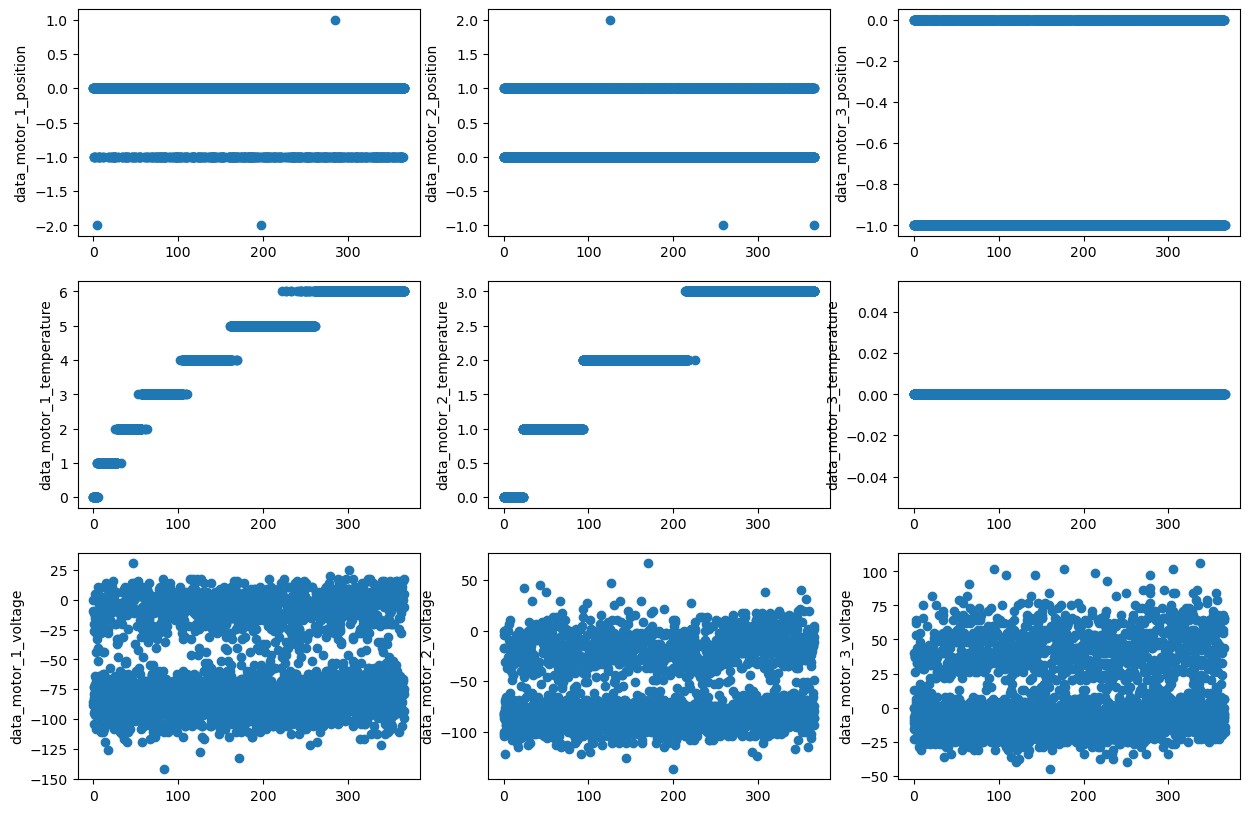

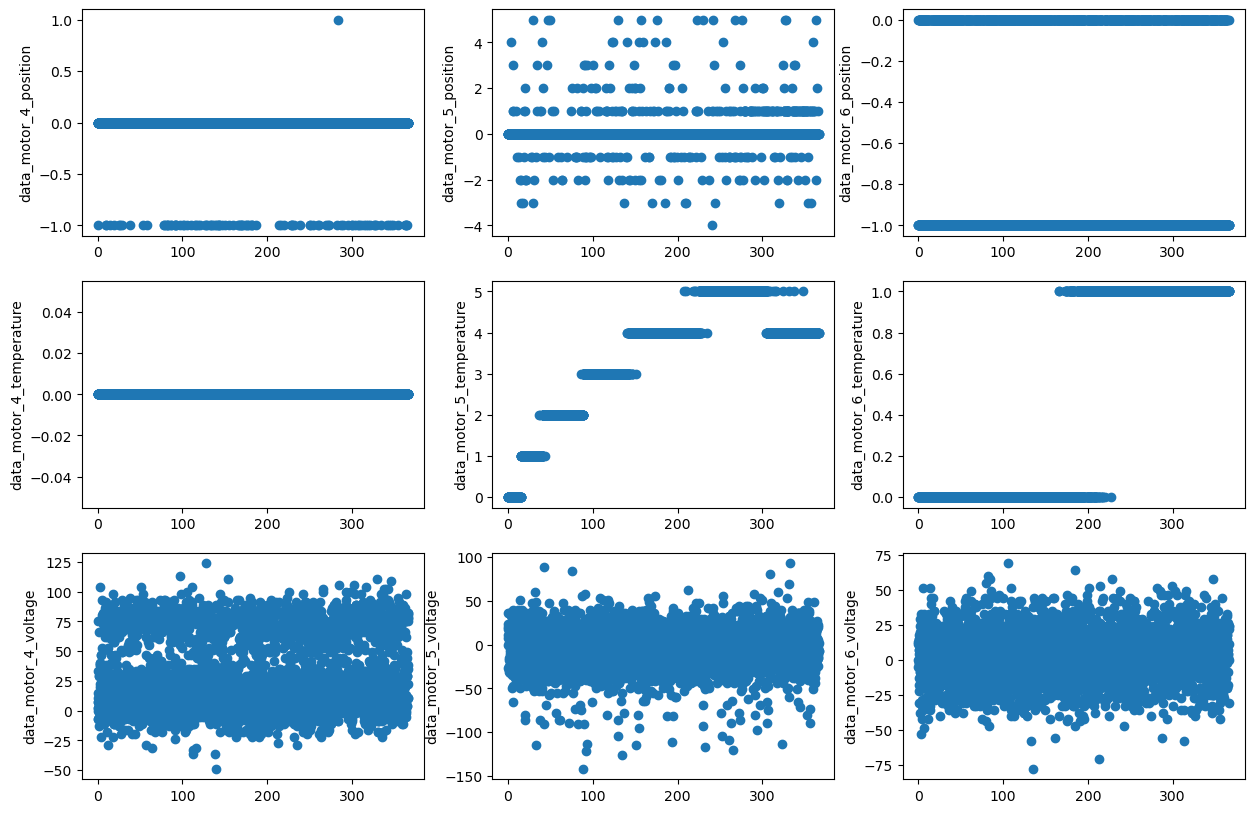

20240105_165300: 1    Pick up and place
Name: Description, dtype: object



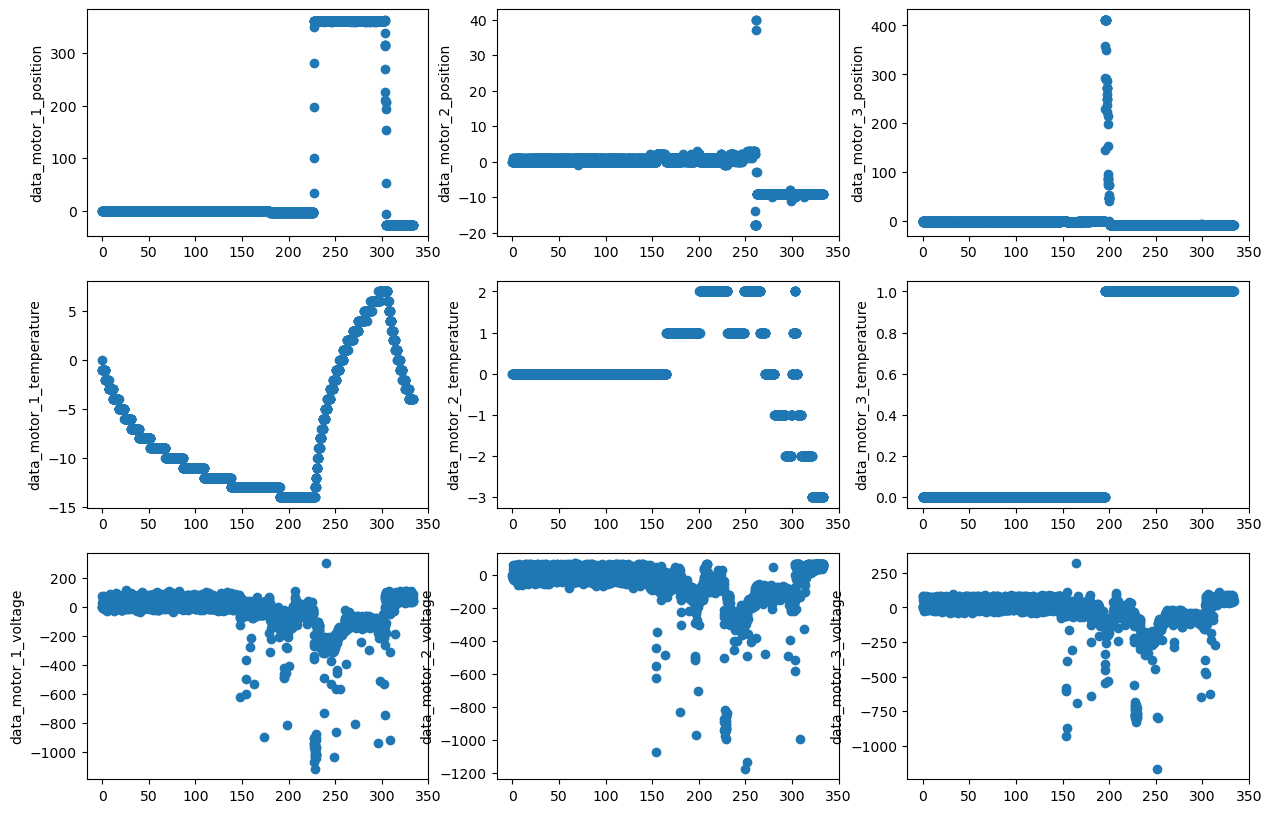

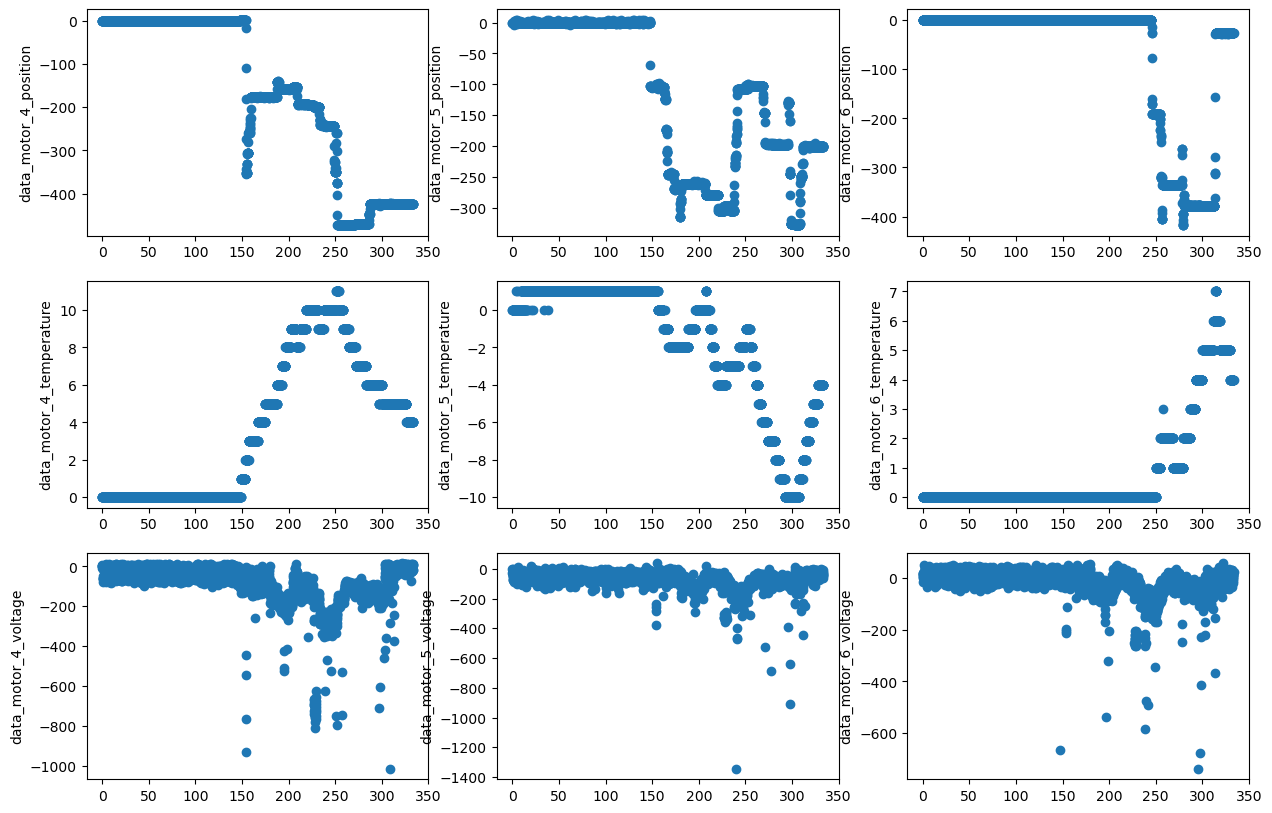

20240105_165972: 2    Not moving
Name: Description, dtype: object



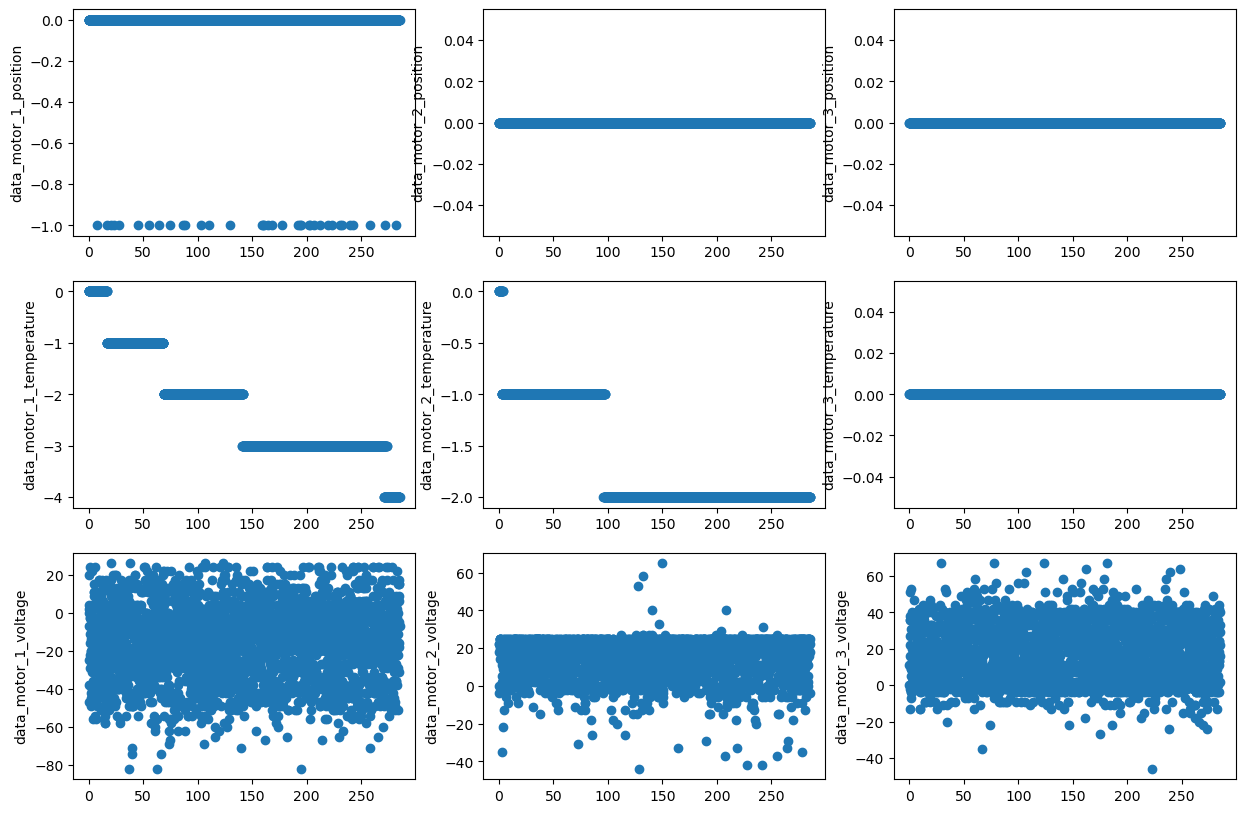

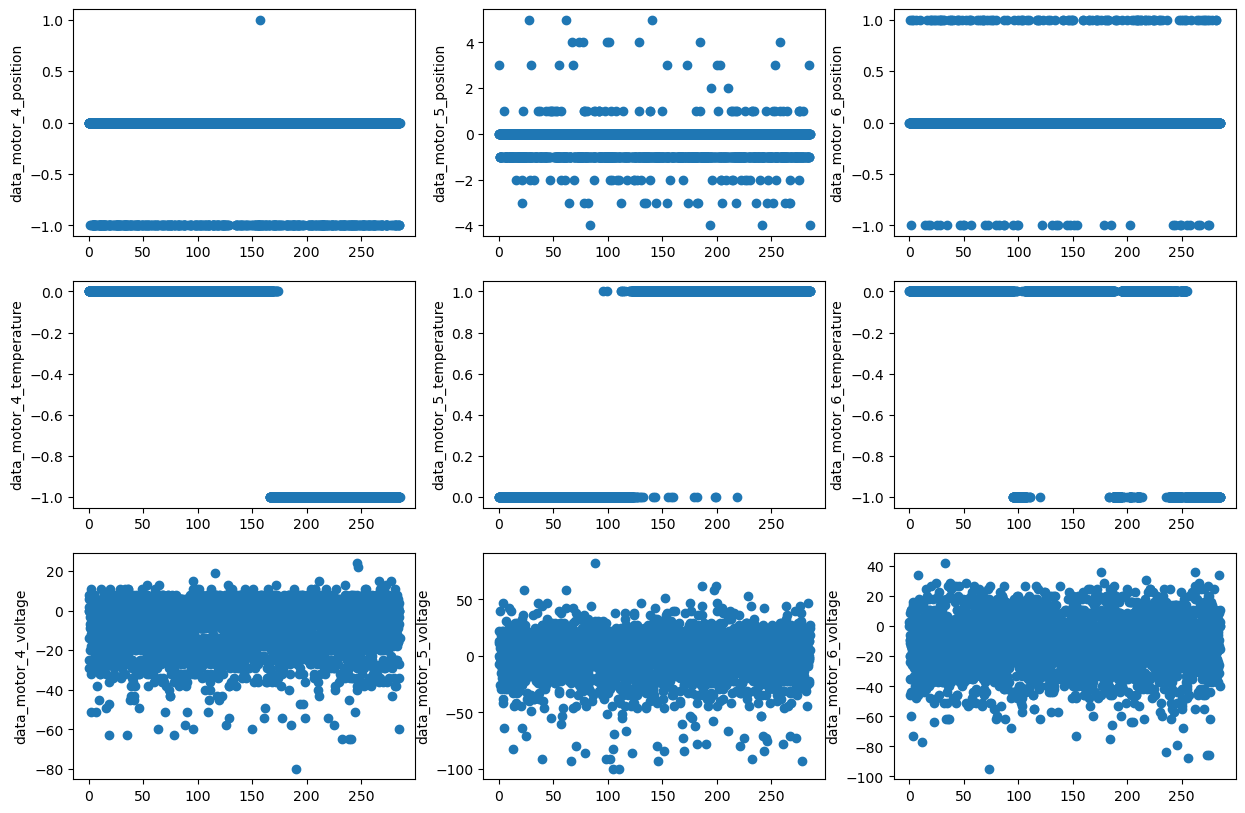

20240320_152031: 3    Not moving
Name: Description, dtype: object



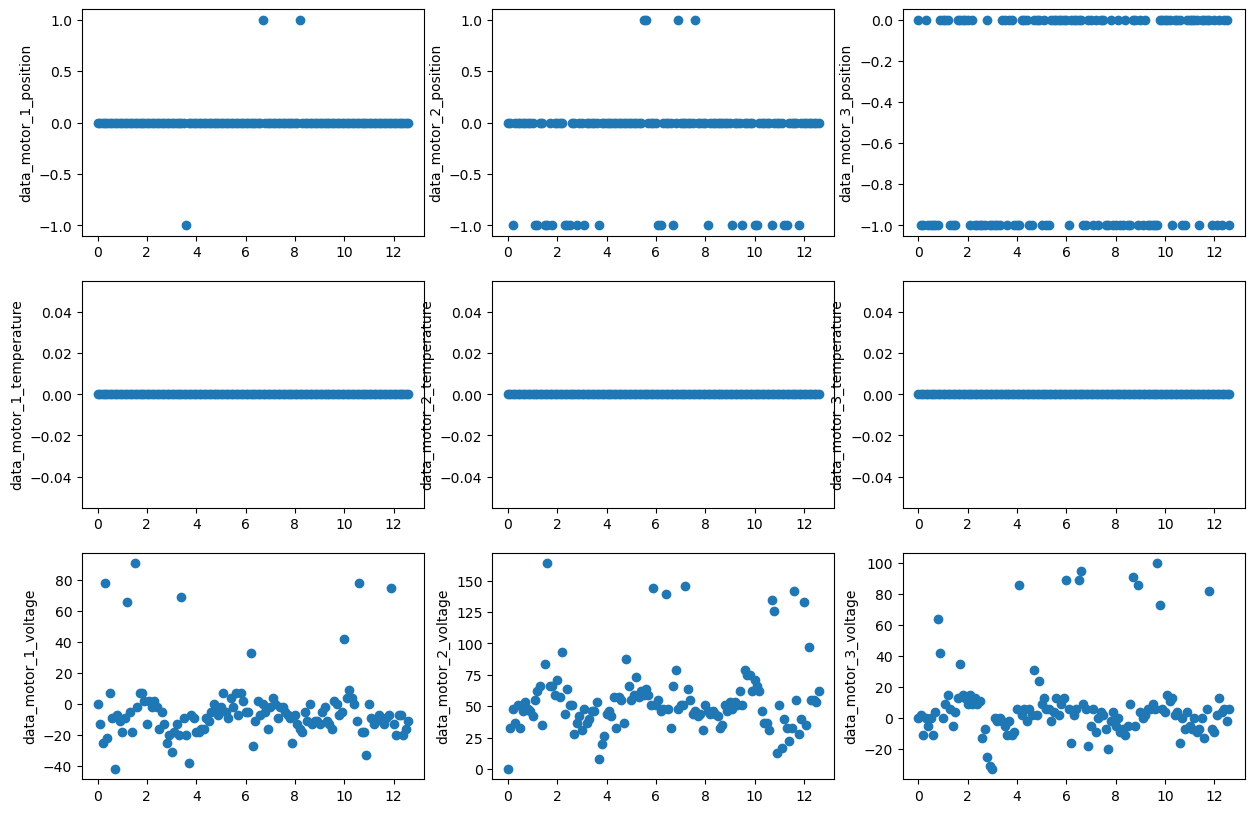

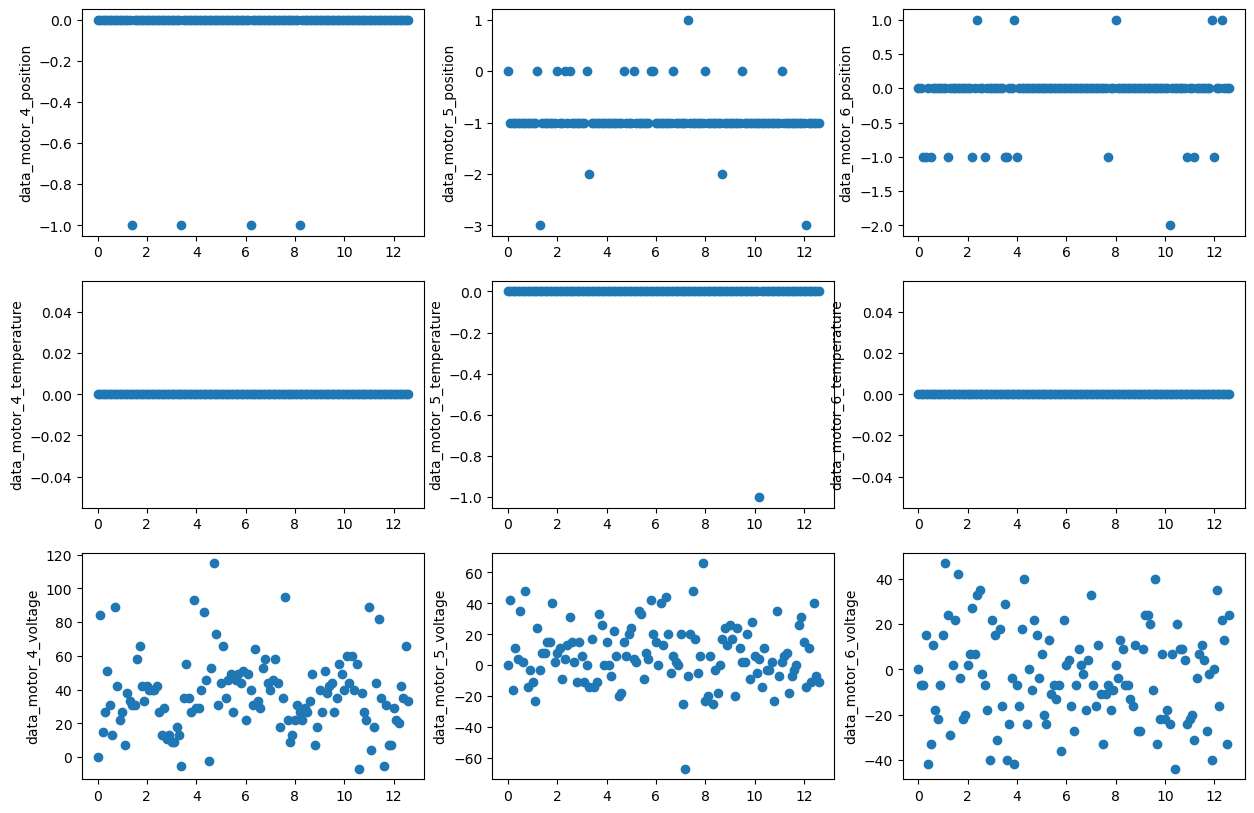

20240320_153841: 4    Move motor 6 -> motor 1 sequentially.
Name: Description, dtype: object



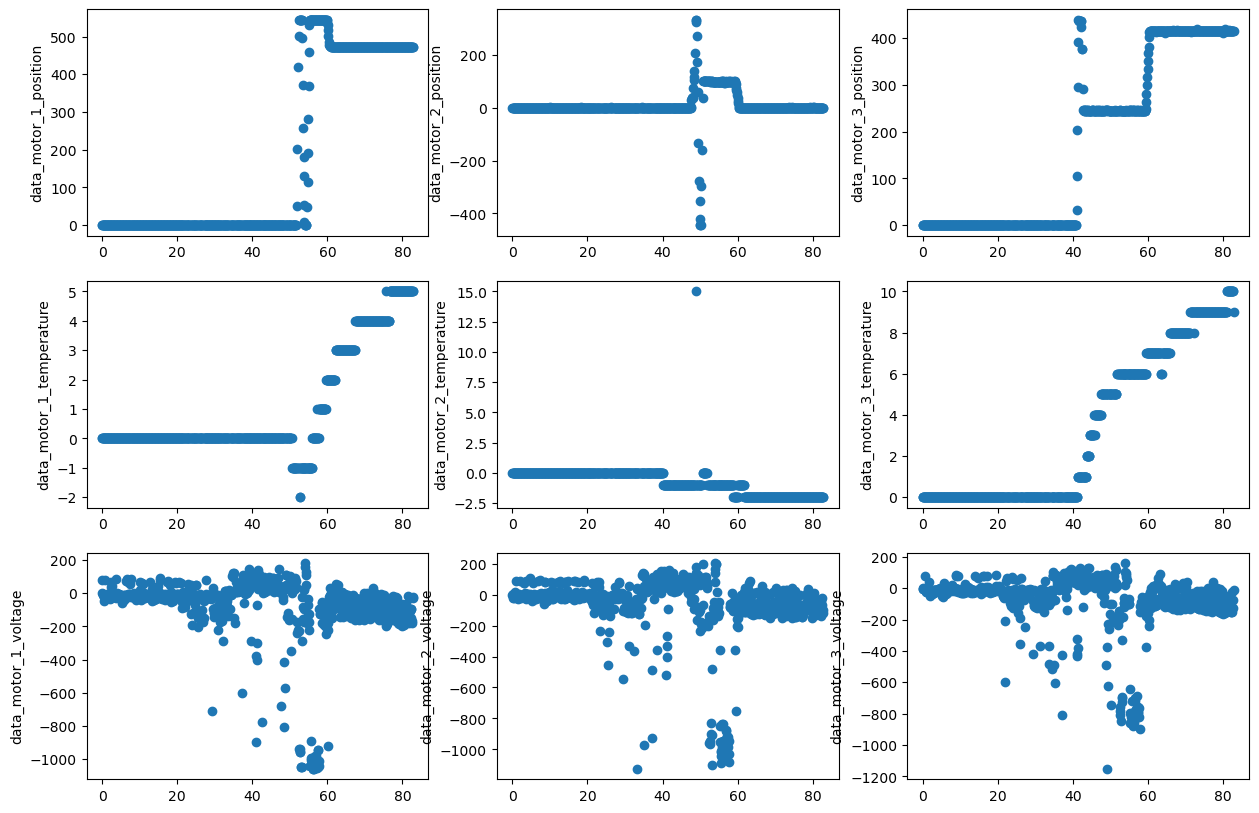

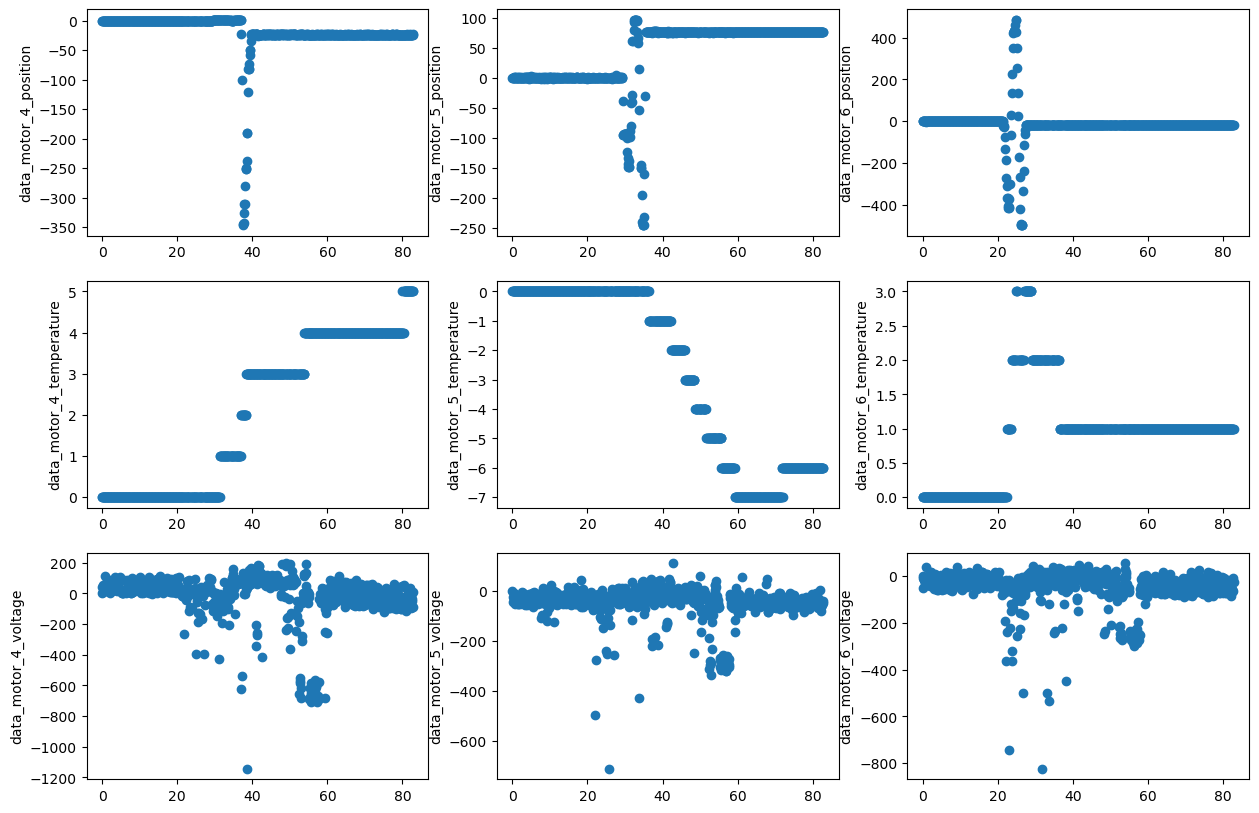

20240320_155664: 5    Not moving
Name: Description, dtype: object



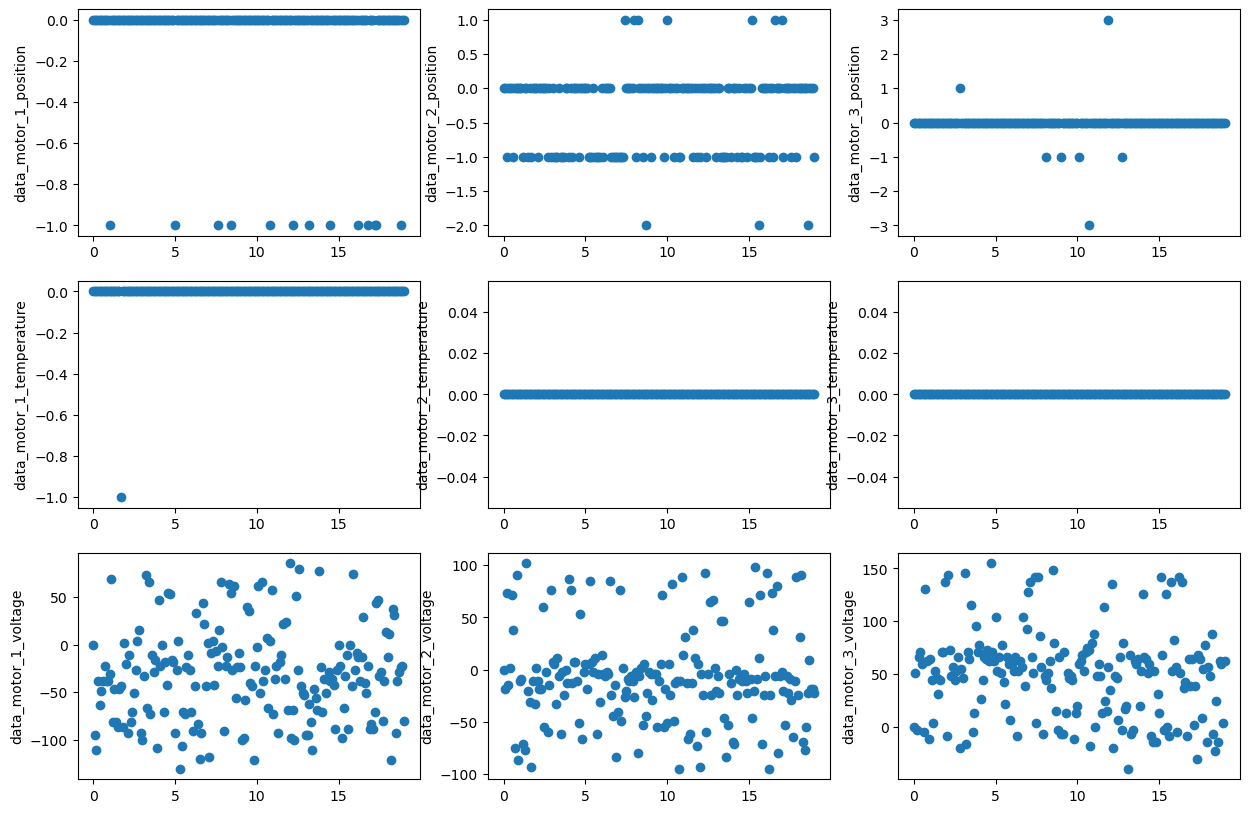

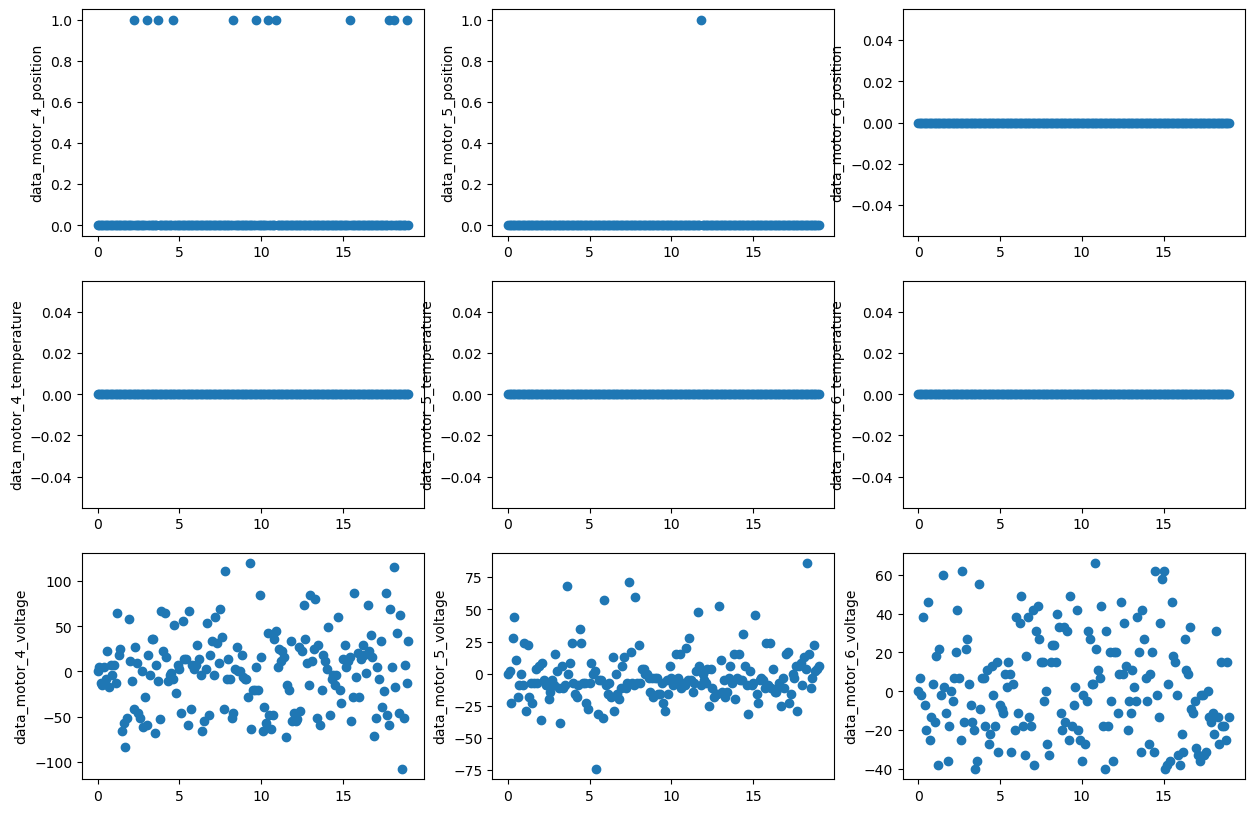

20240321_122650: 6    Pick up and place
Name: Description, dtype: object



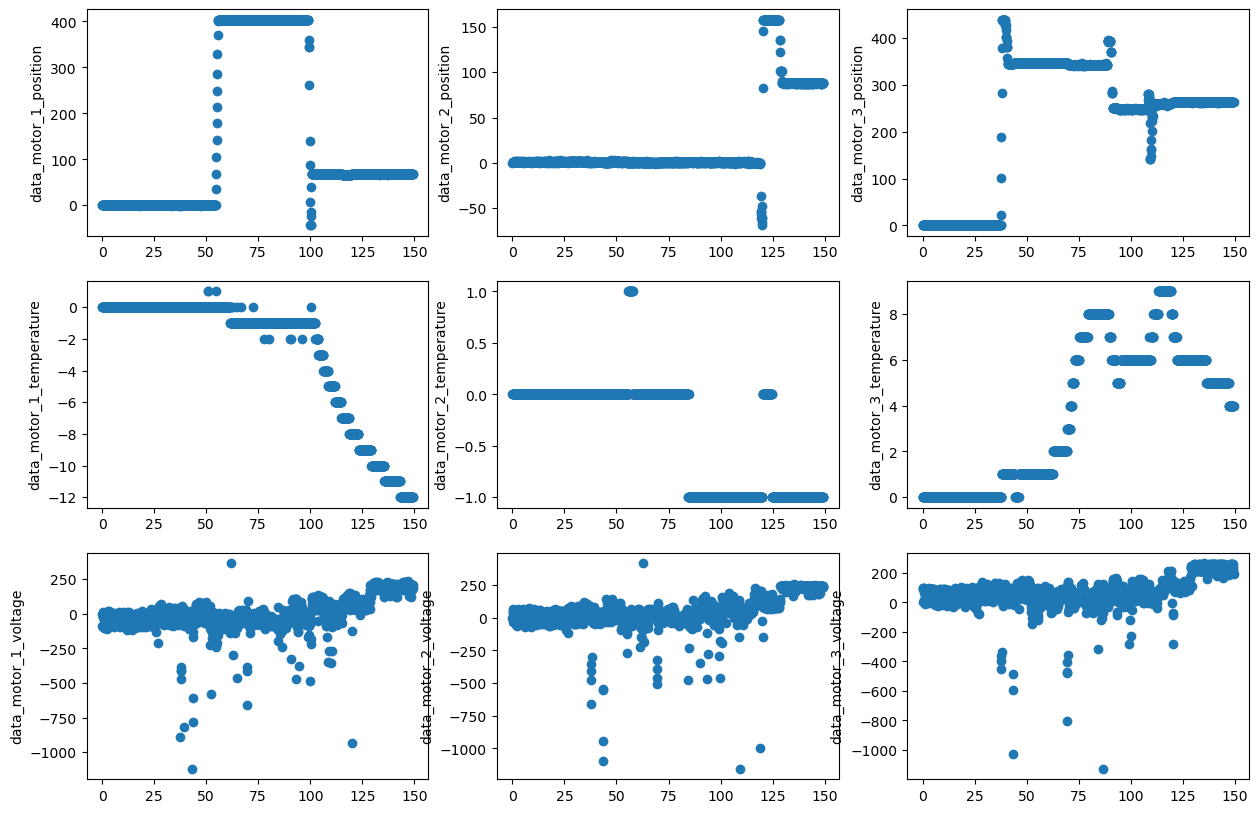

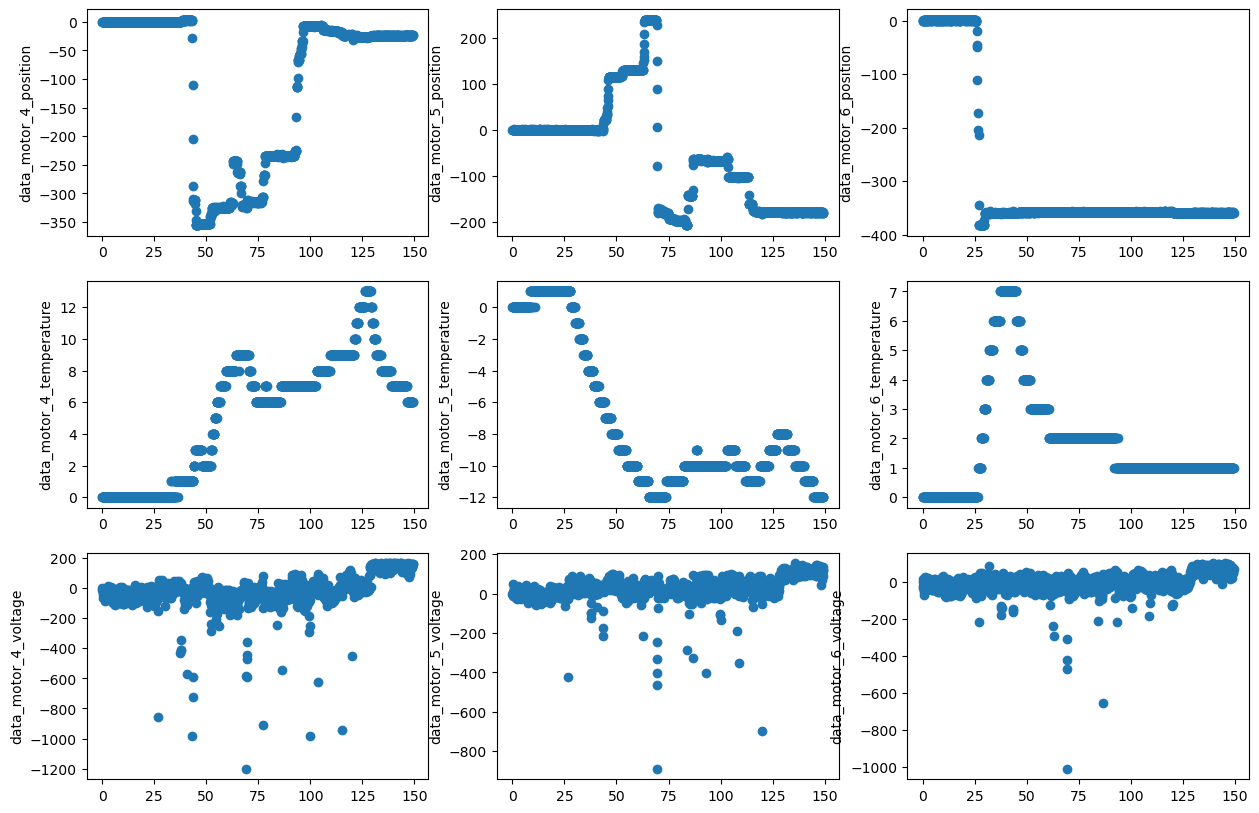

20240325_135213: 7    Not moving
Name: Description, dtype: object



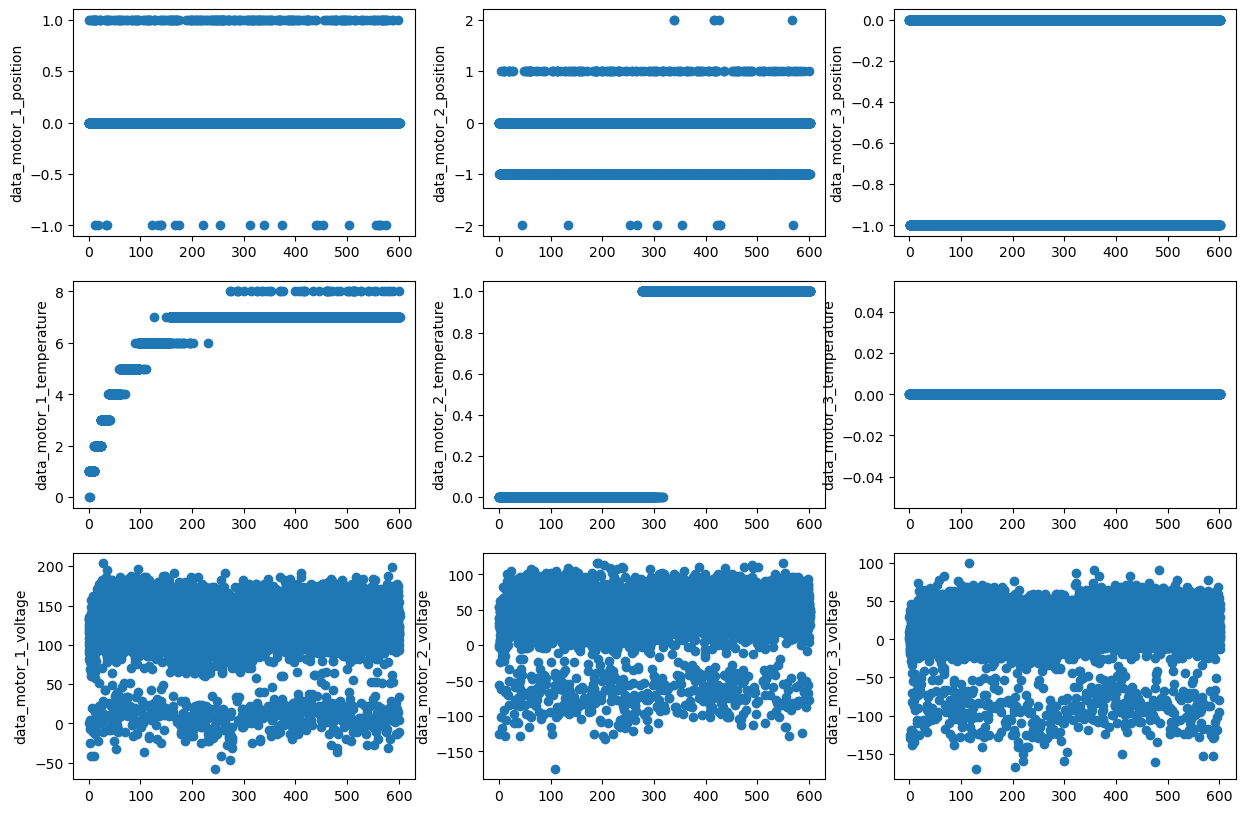

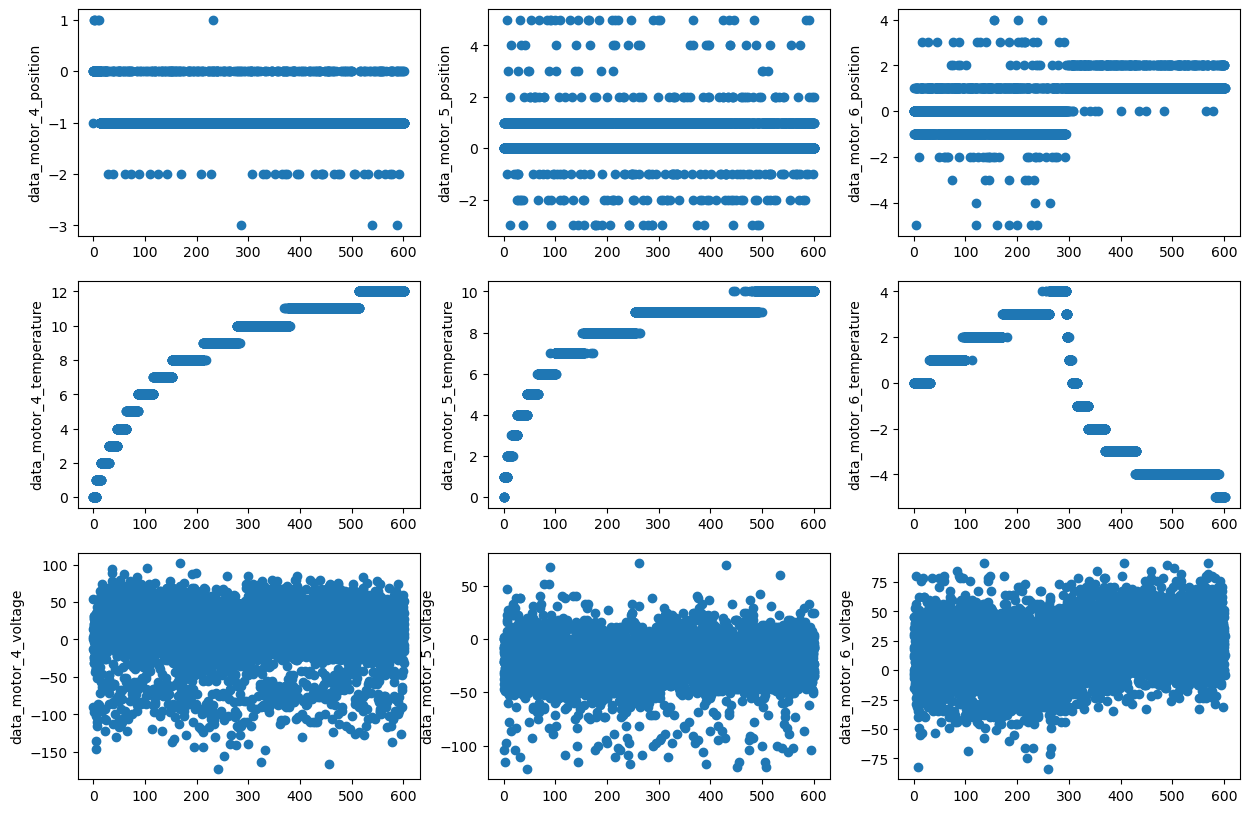

20240325_152902: 8    Pick up and place
Name: Description, dtype: object



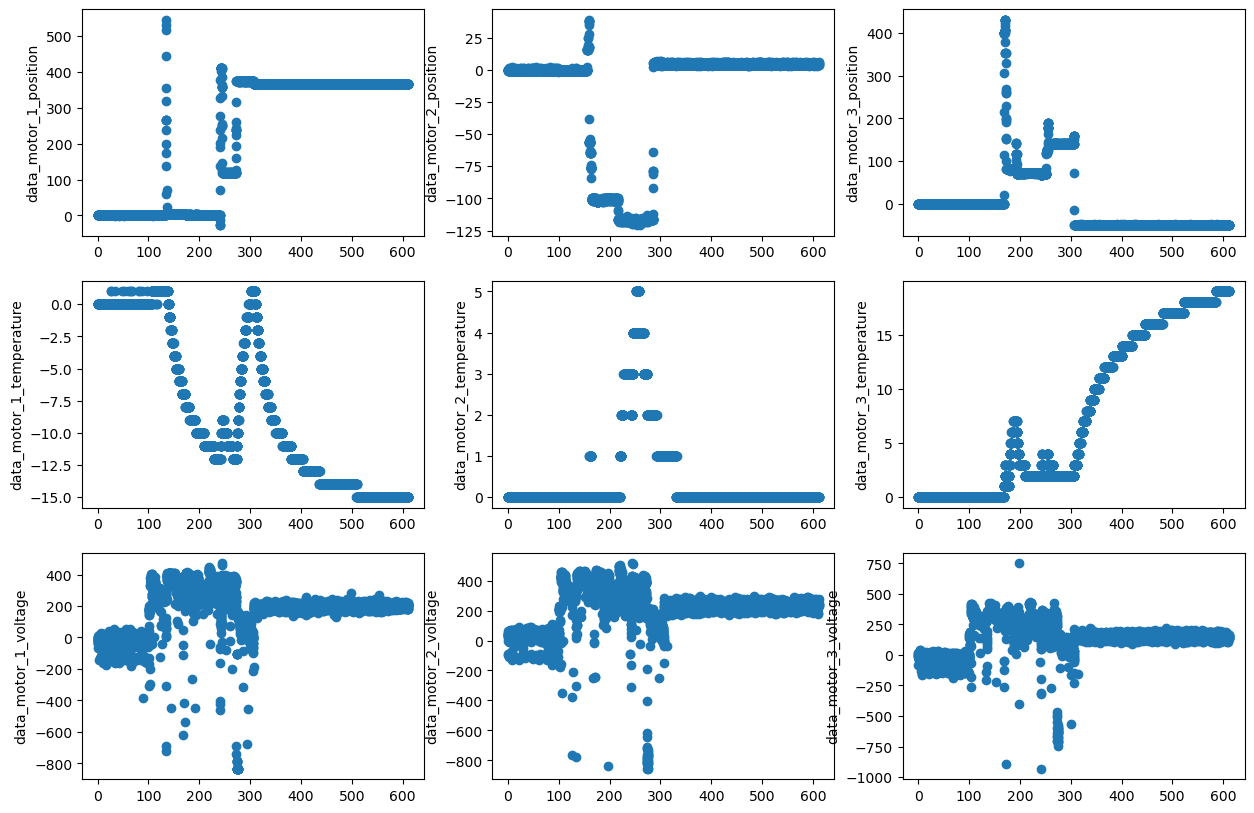

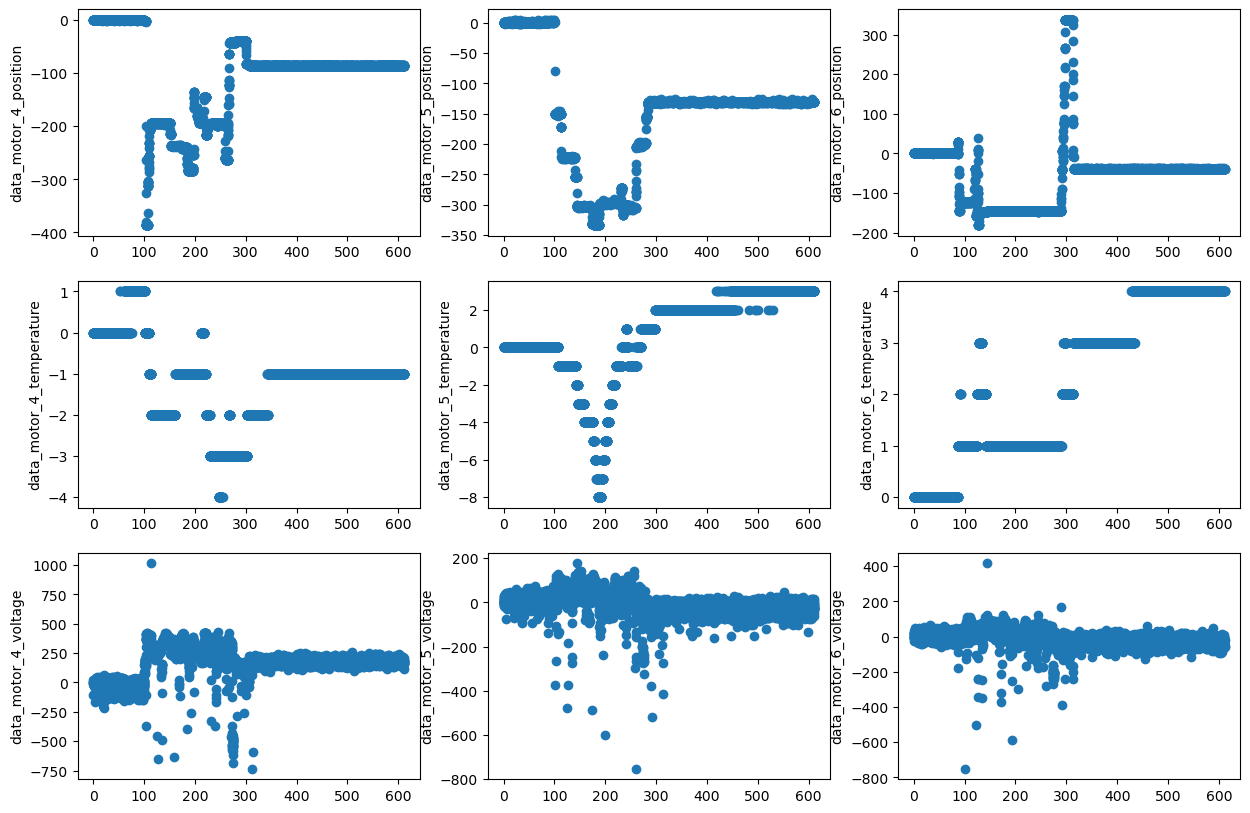

20240325_155003: 9    Pick up and place
Name: Description, dtype: object



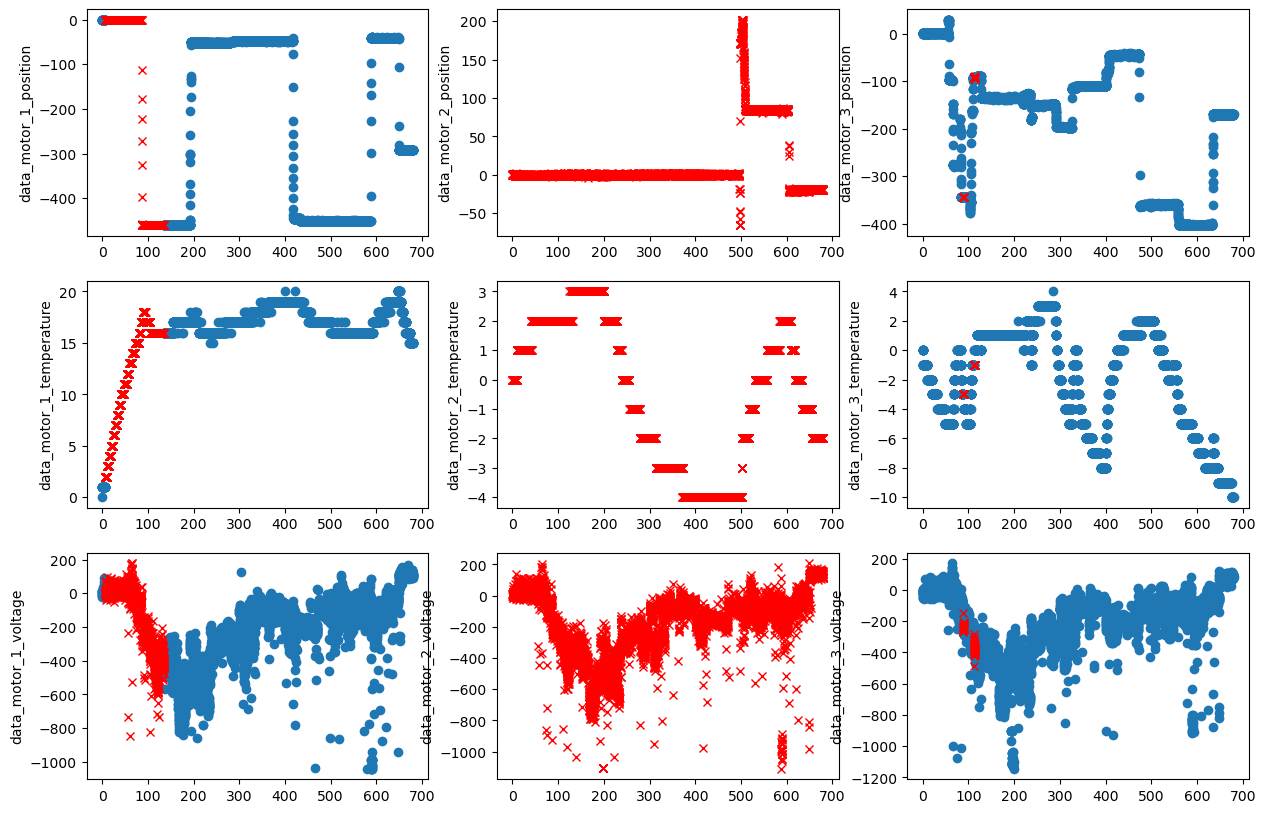

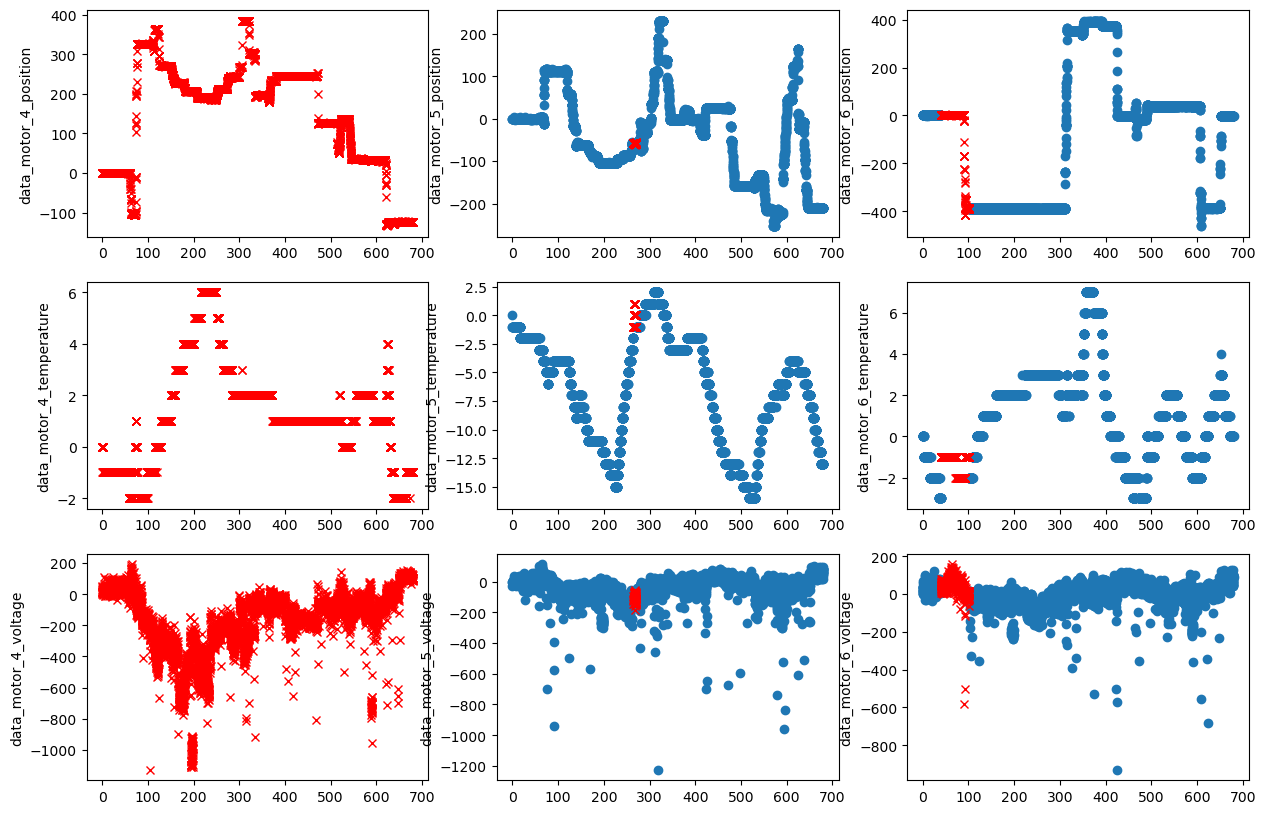

20240425_093699: 10    Not moving
Name: Description, dtype: object



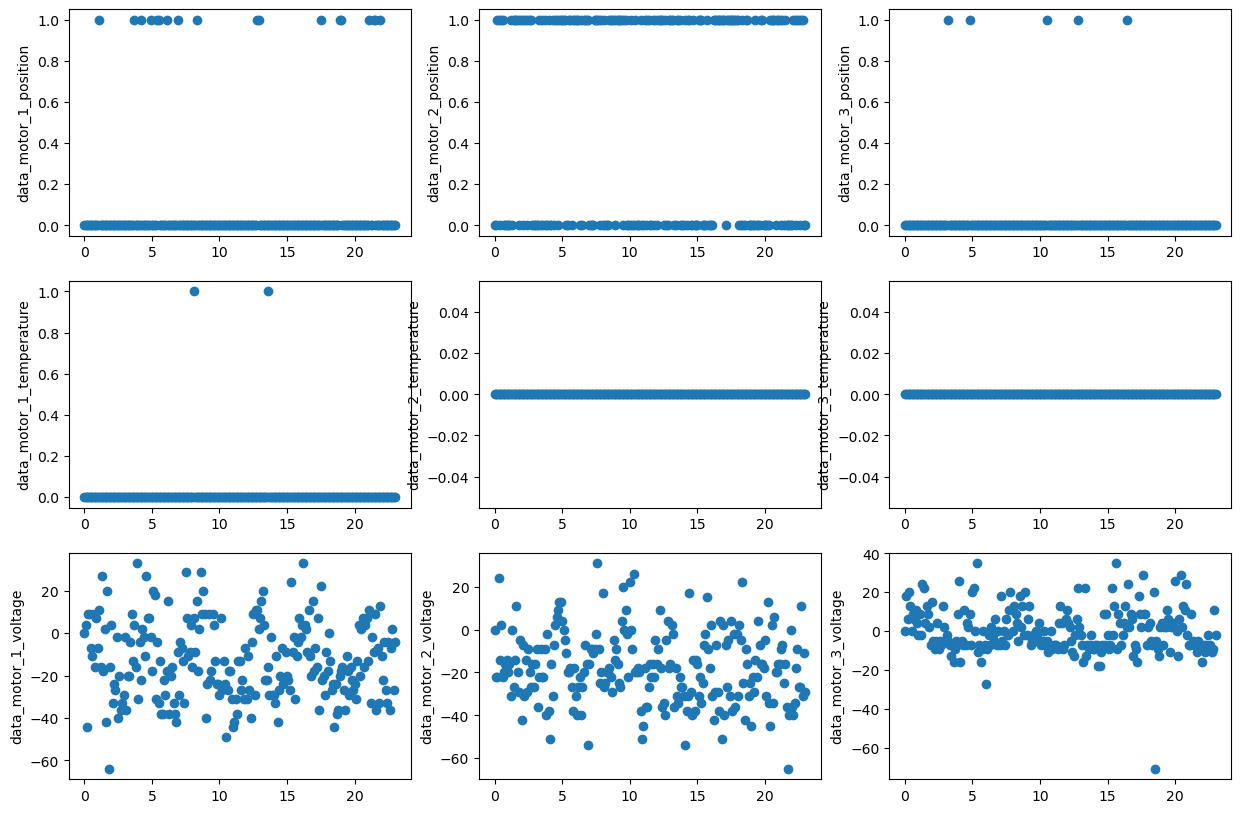

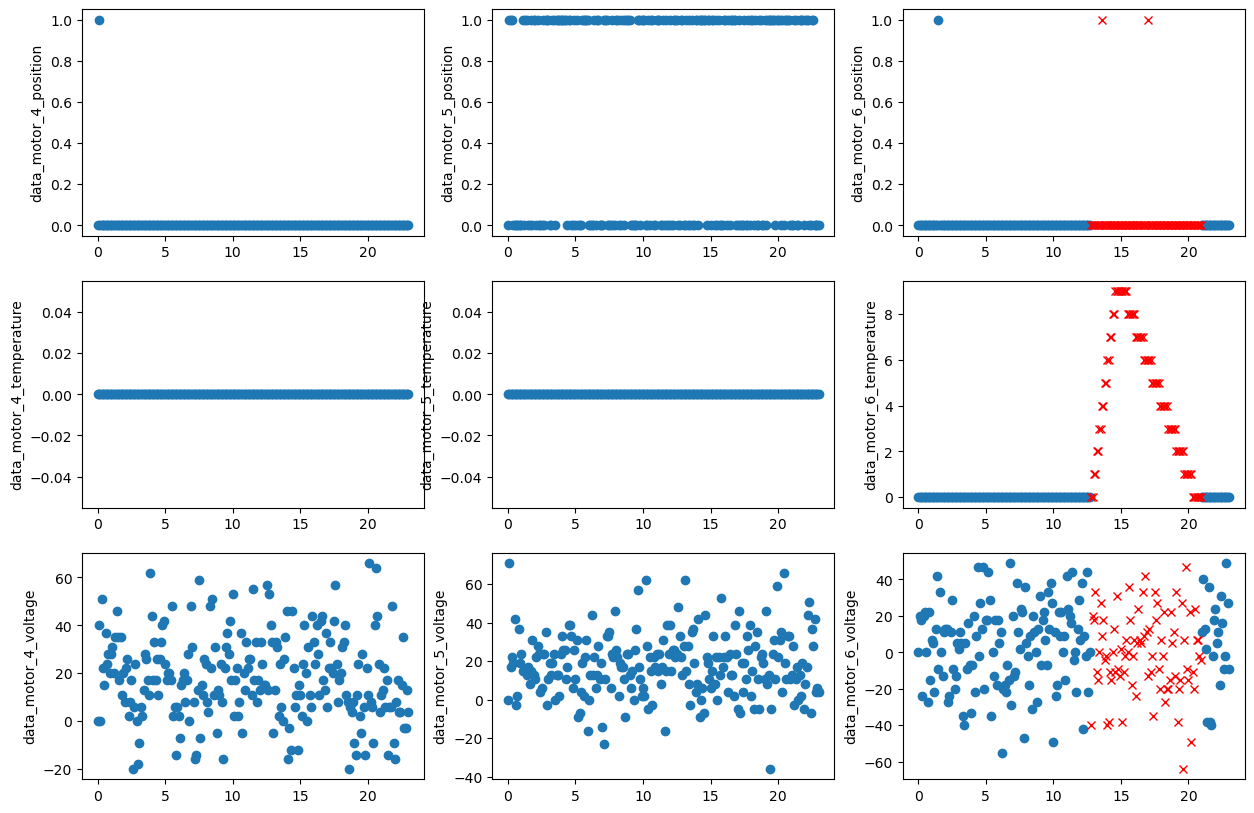

20240425_094425: 11    Not moving
Name: Description, dtype: object



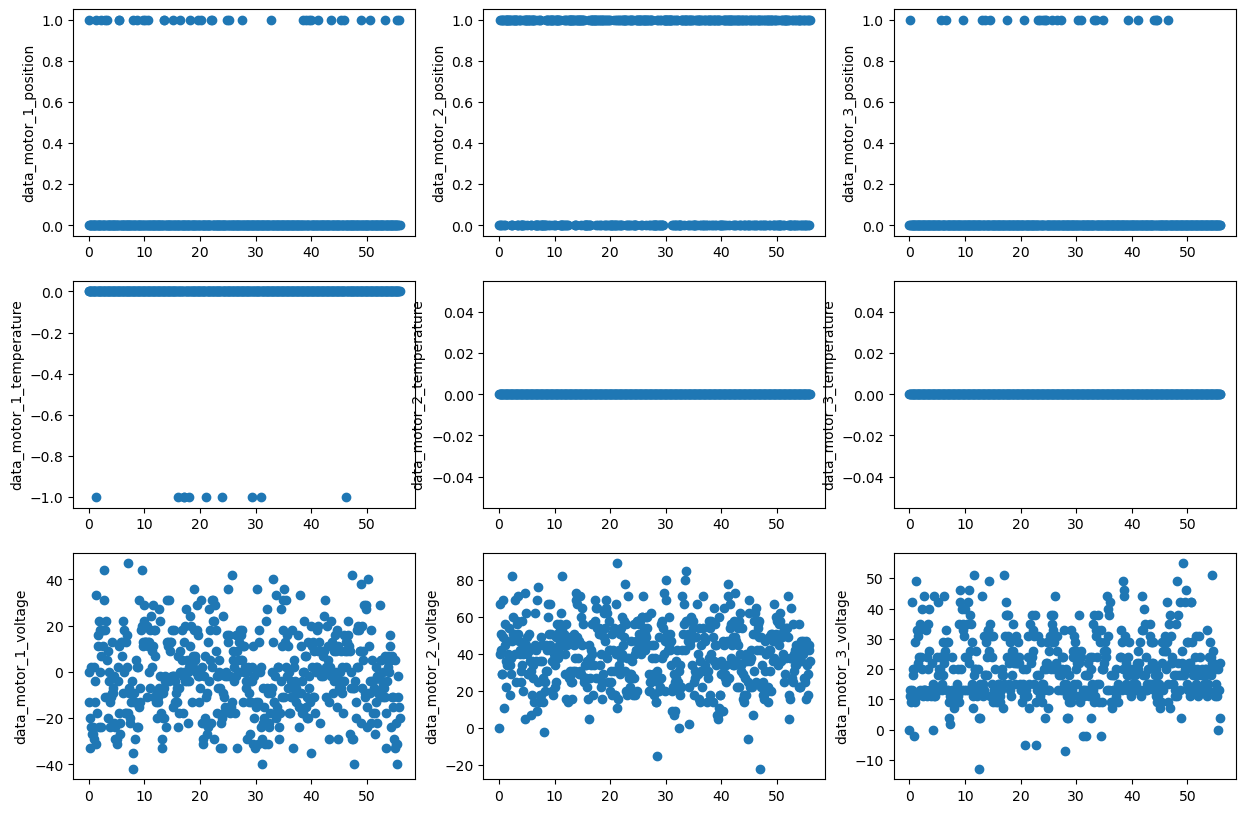

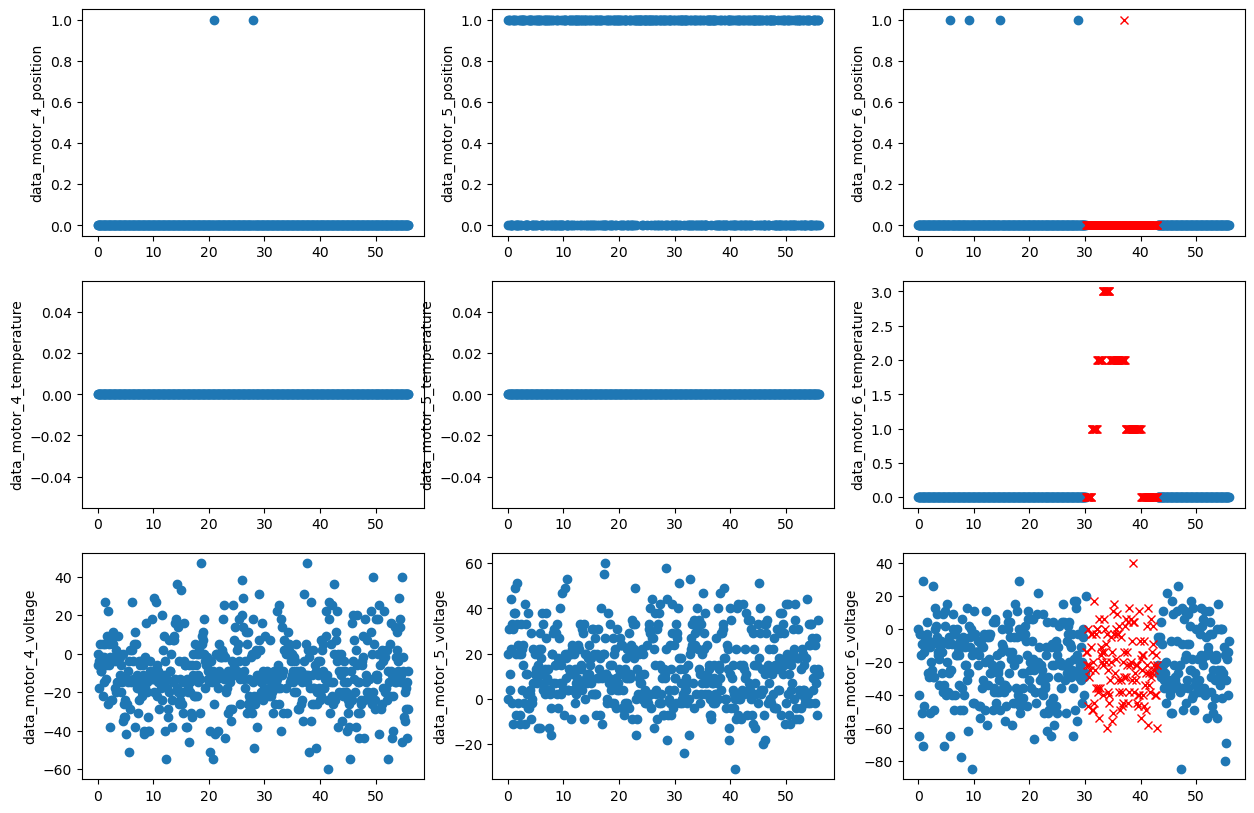

20240426_140055: 12    Not moving
Name: Description, dtype: object



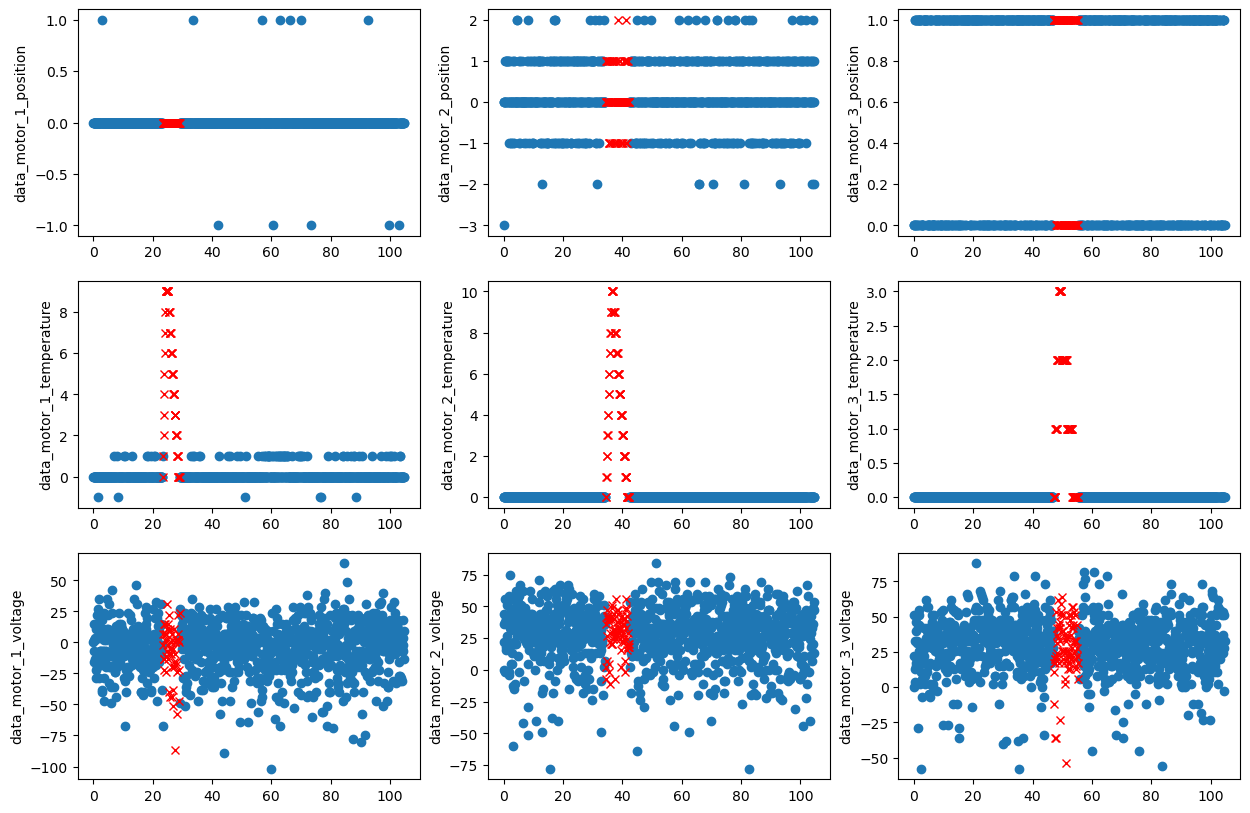

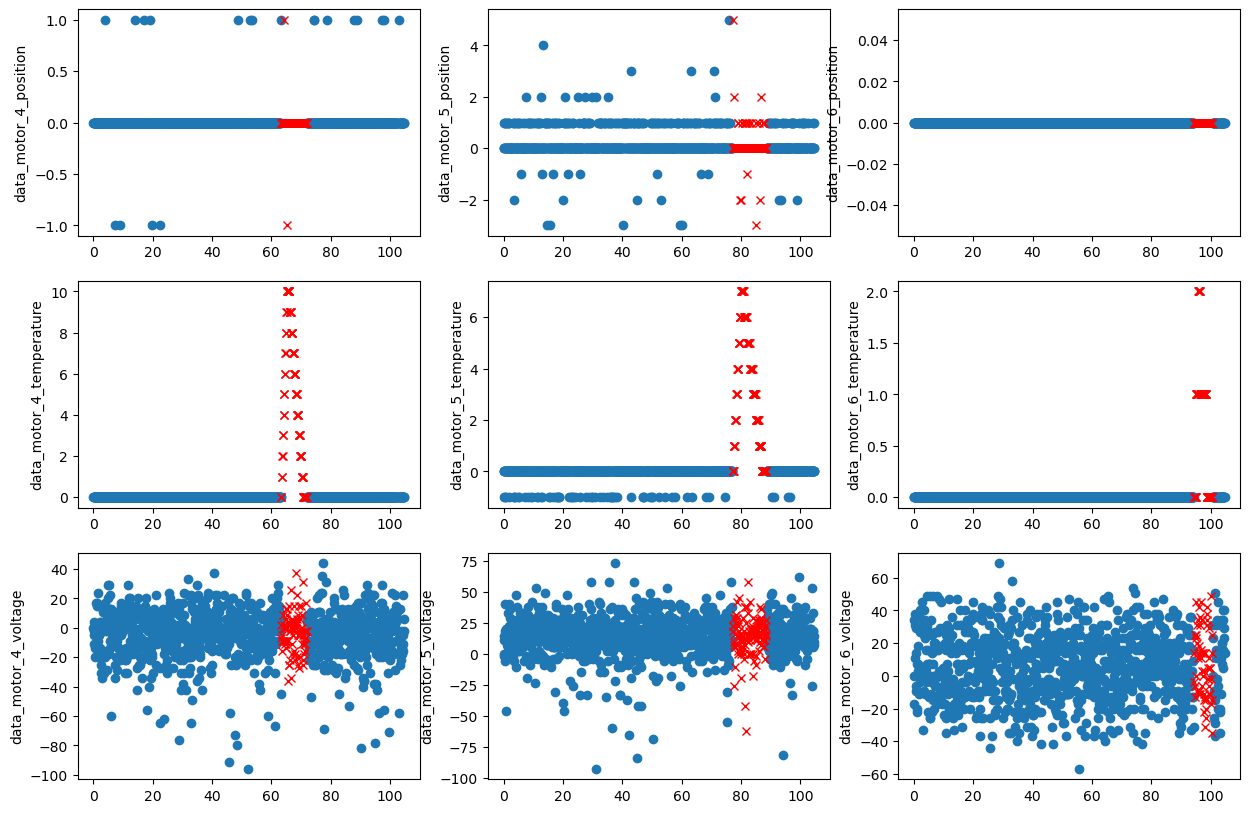

20240426_141190: 13    Pick up and place
Name: Description, dtype: object



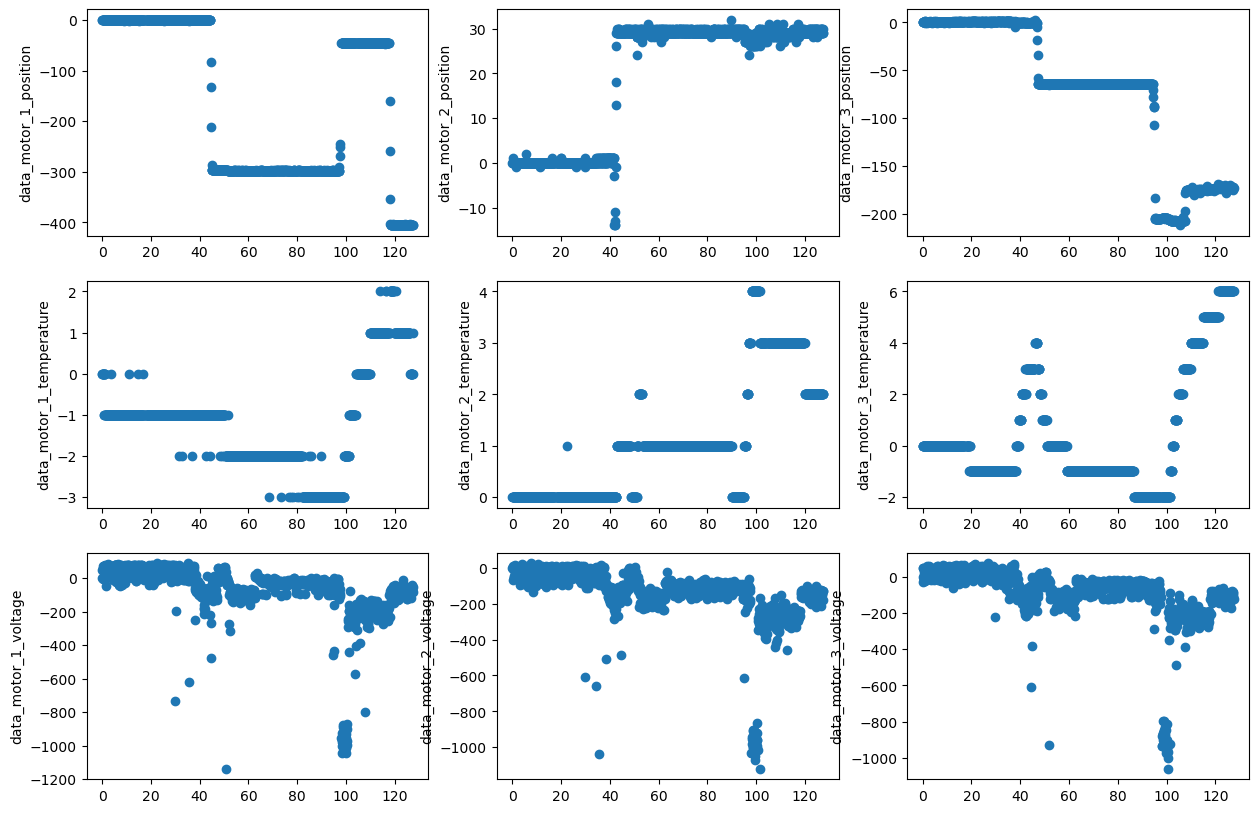

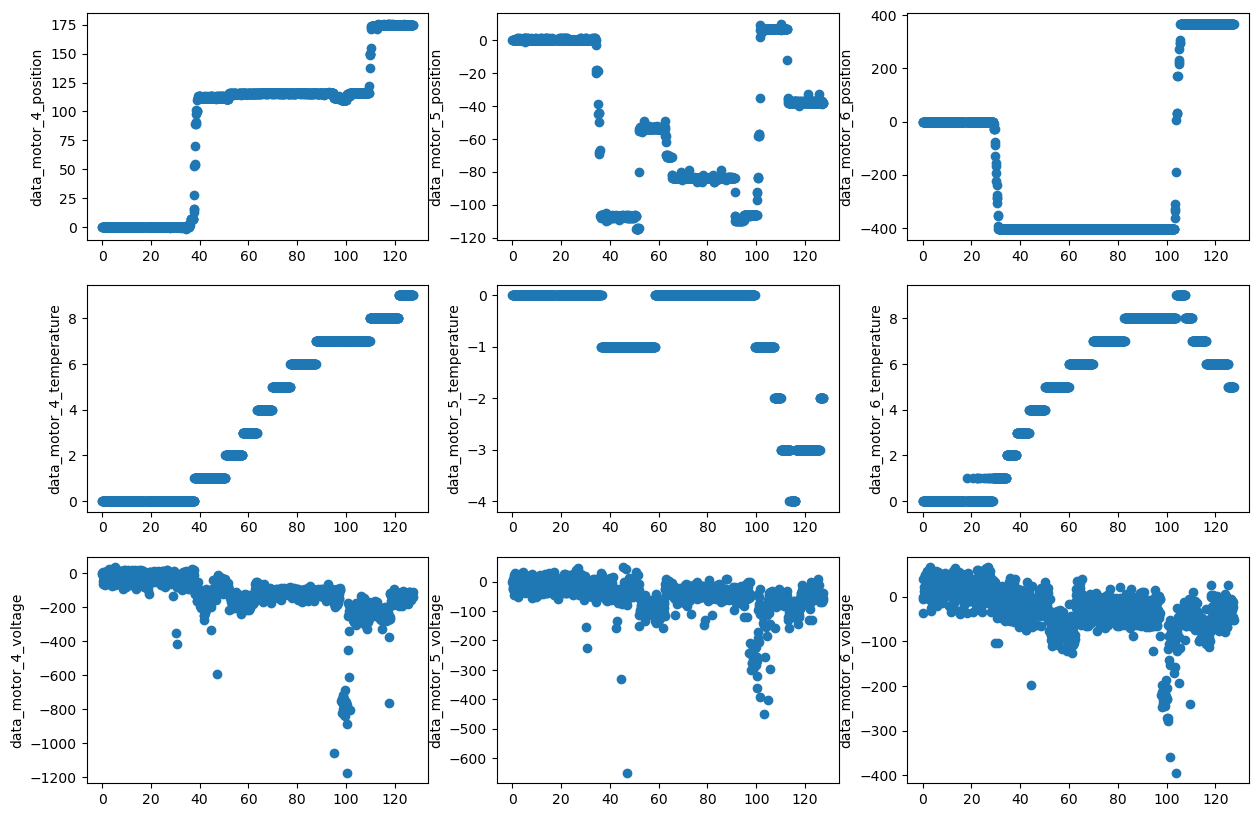

20240426_141532: 14    Moving one motor
Name: Description, dtype: object



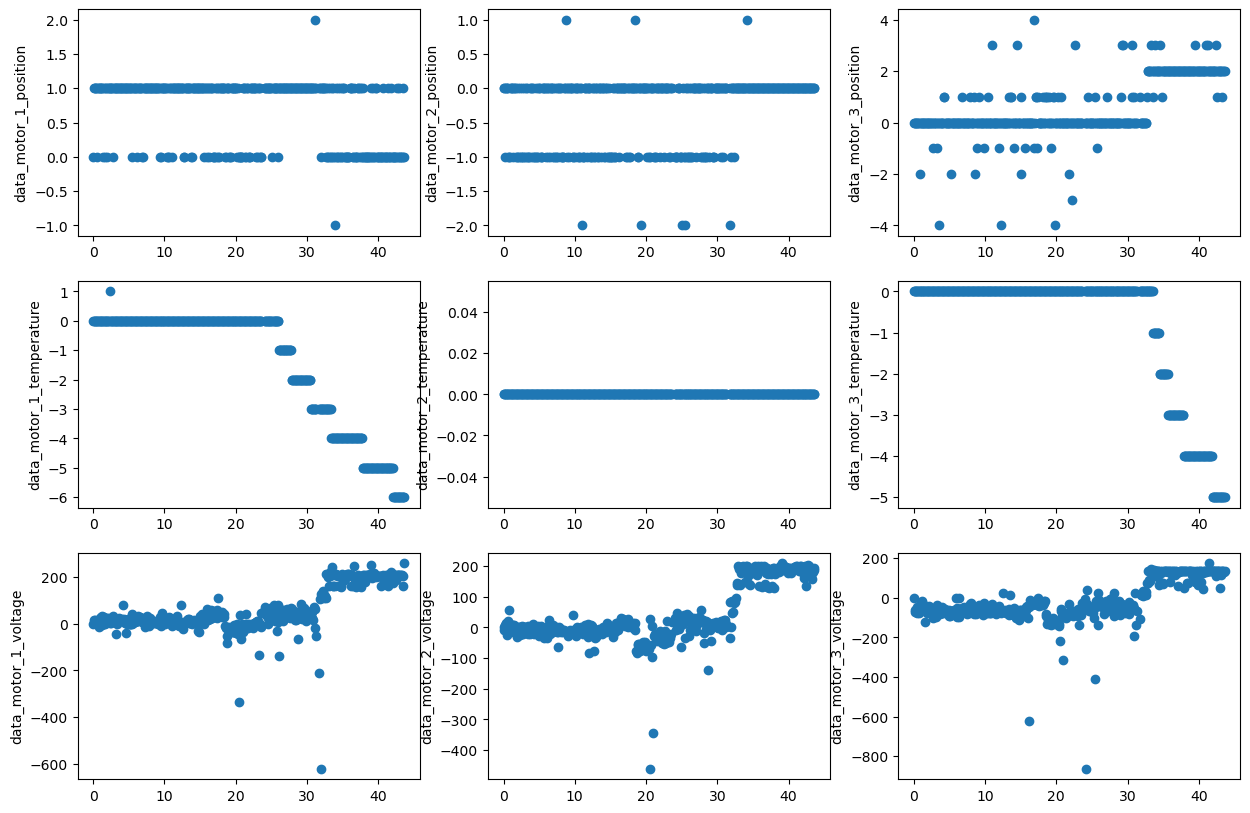

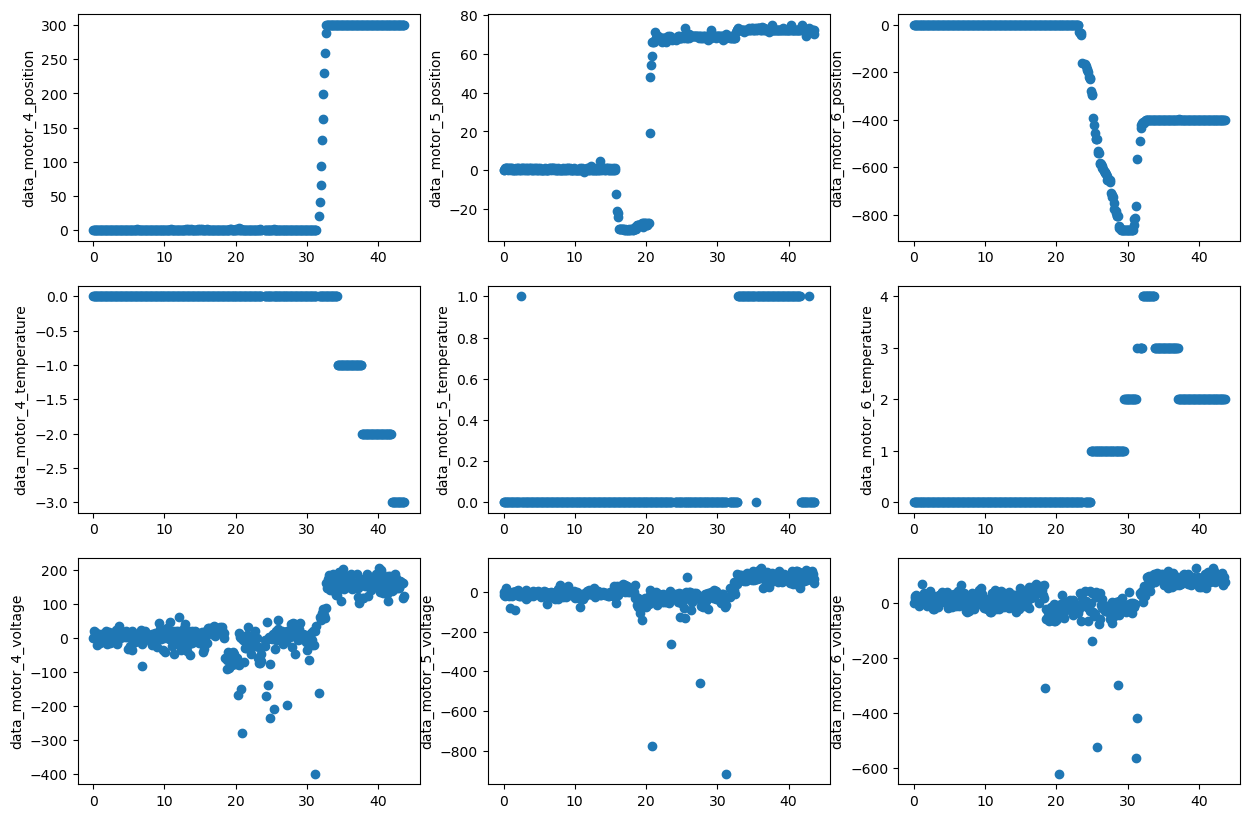

20240426_141602: 15    Moving one motor
Name: Description, dtype: object



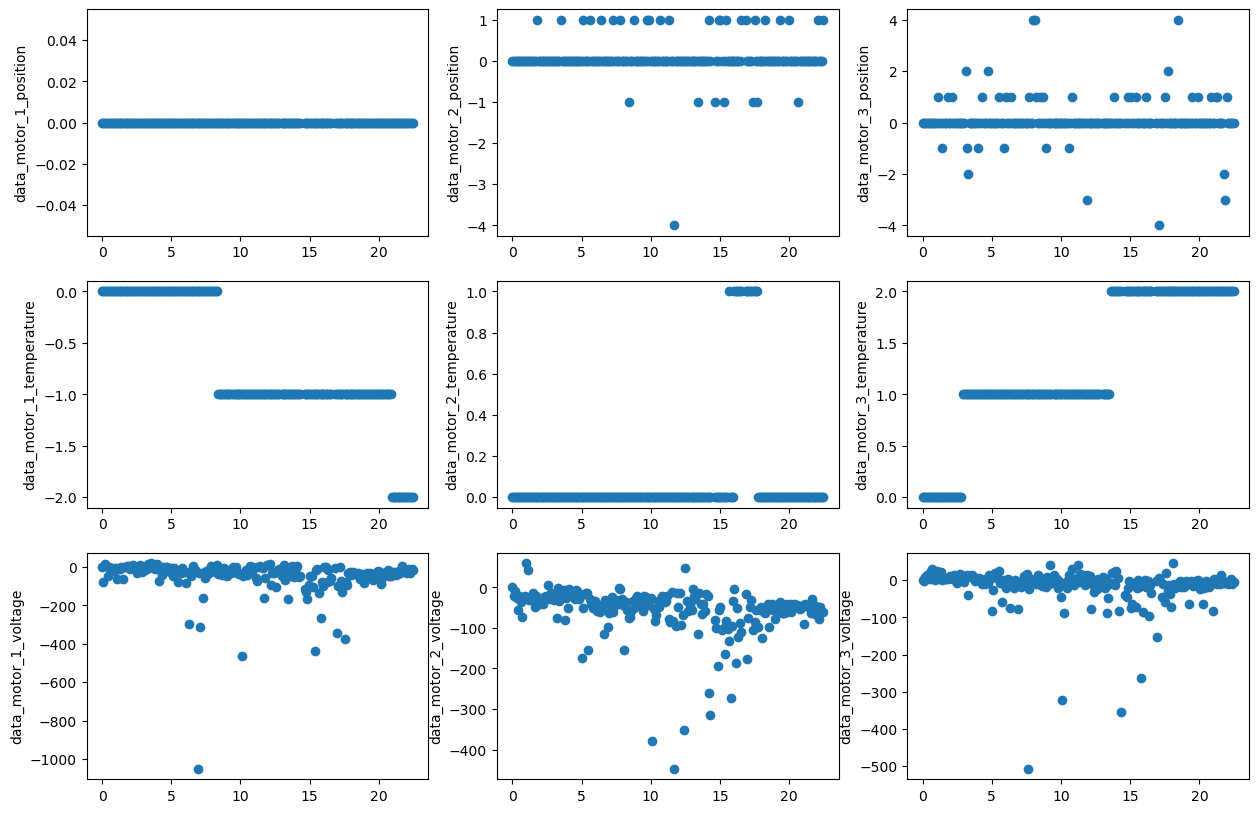

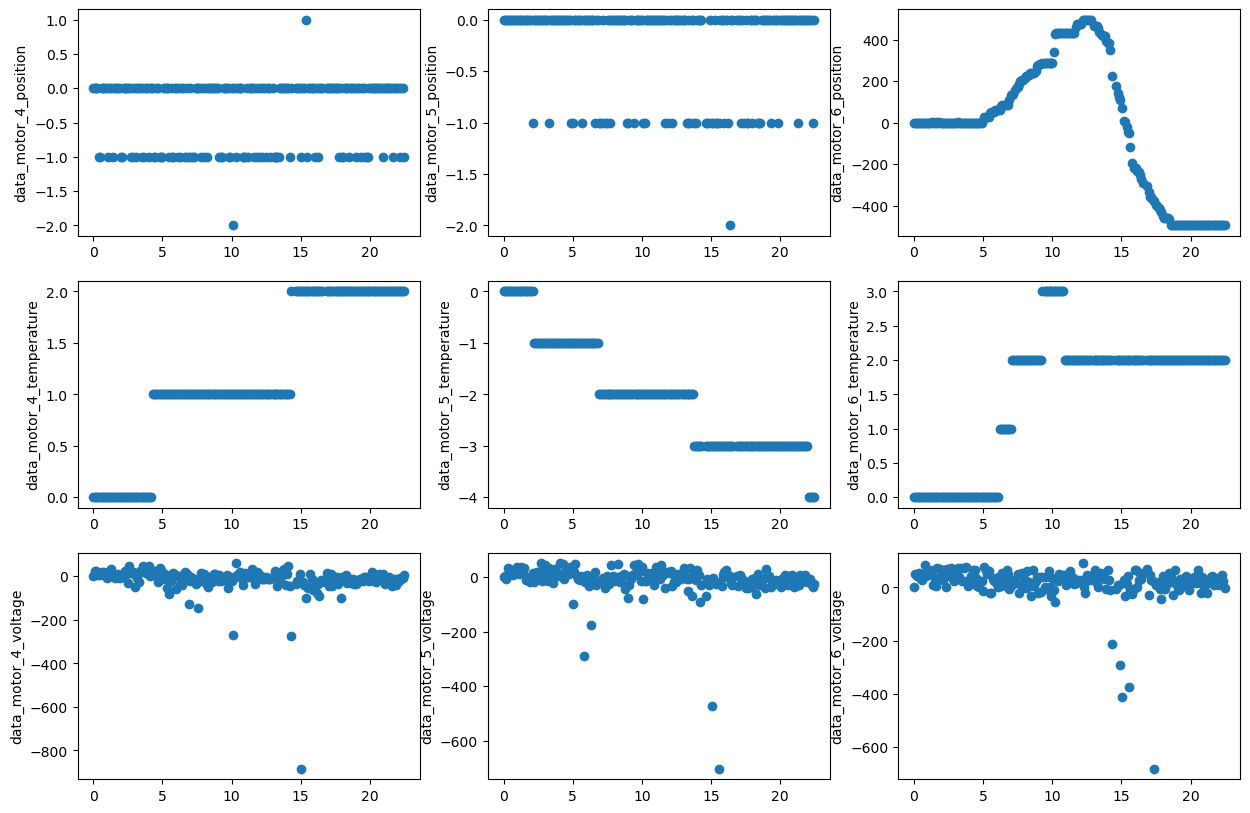

20240426_141726: 16    Moving one motor
Name: Description, dtype: object



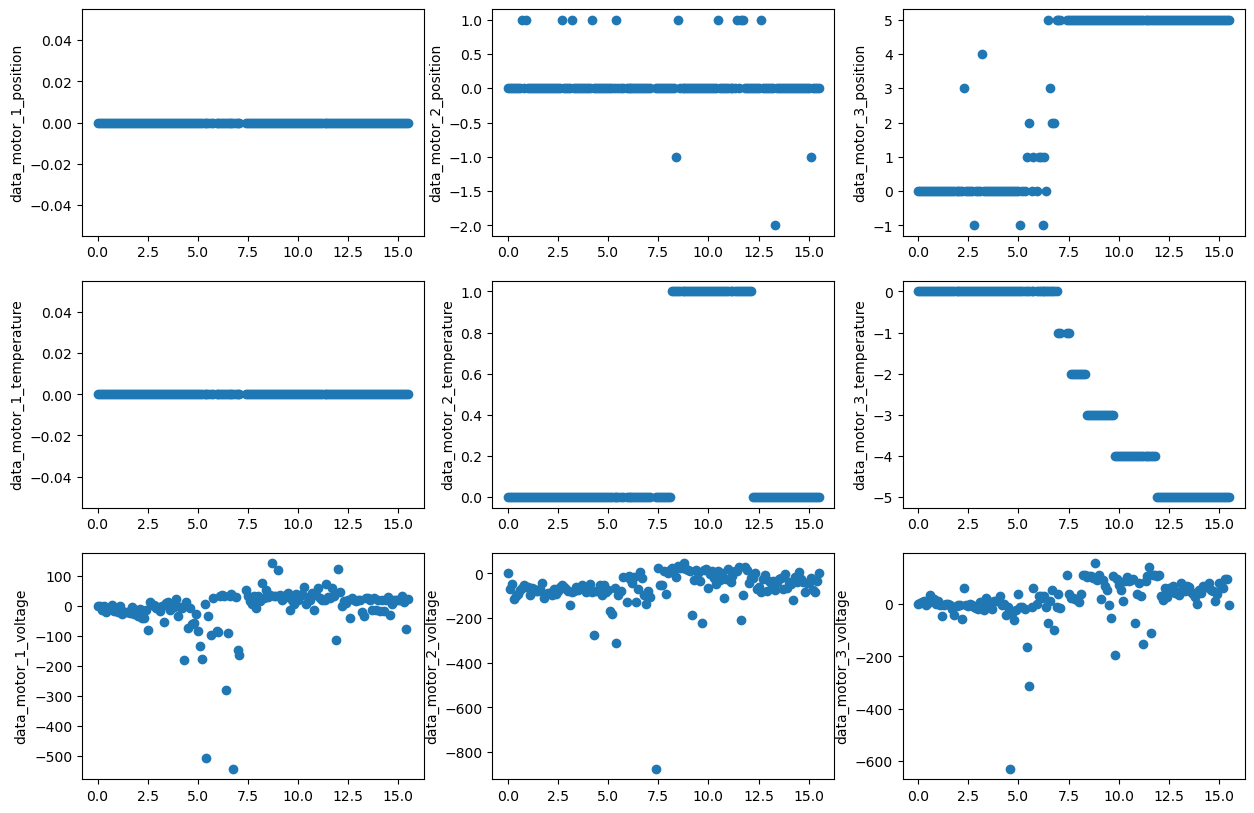

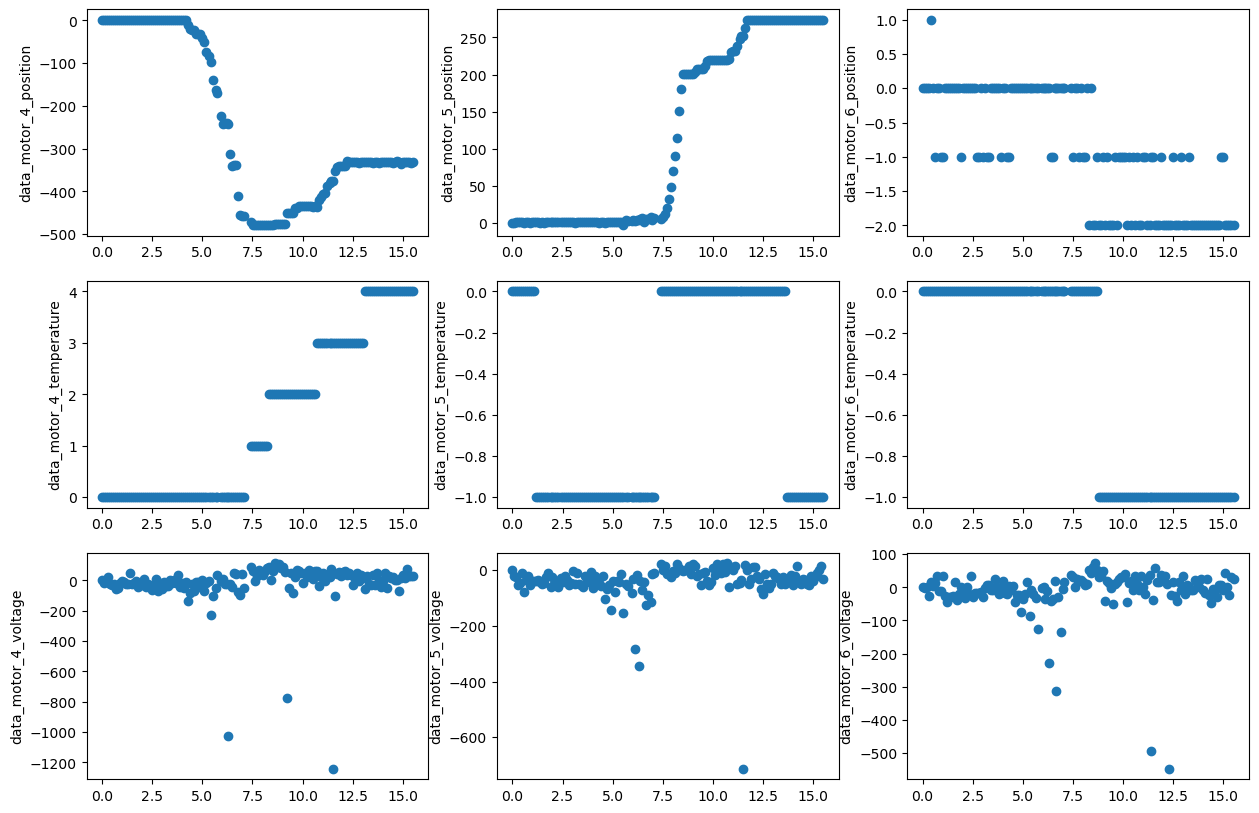

20240426_141938: 17    Moving one motor
Name: Description, dtype: object



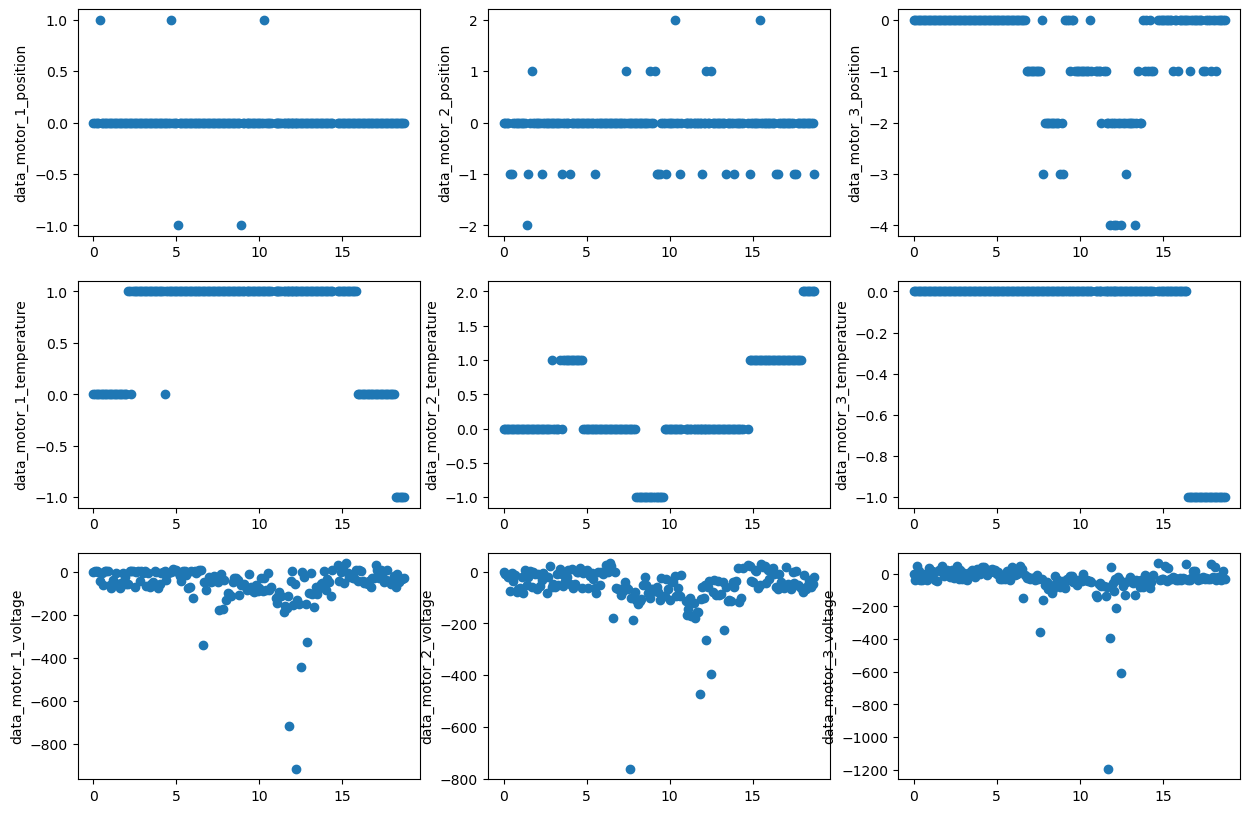

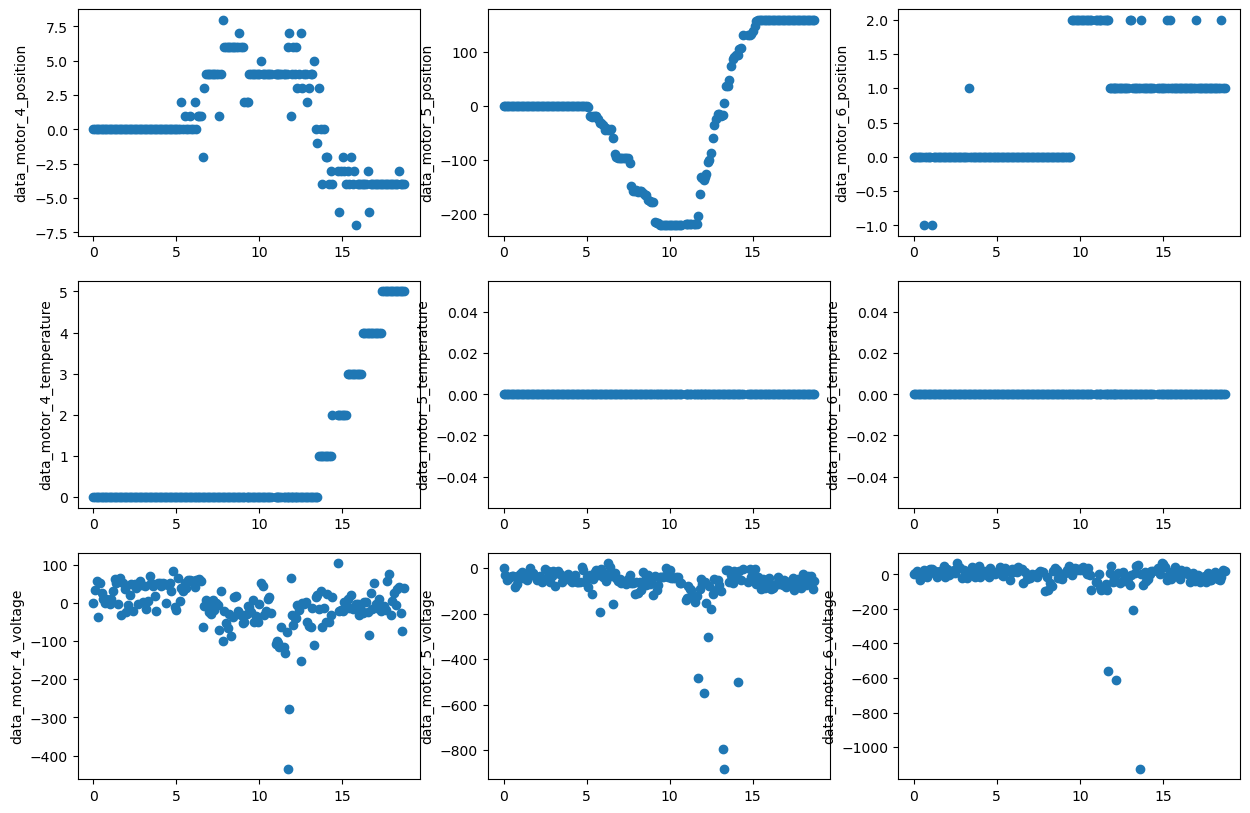

20240426_141980: 18    Moving one motor
Name: Description, dtype: object



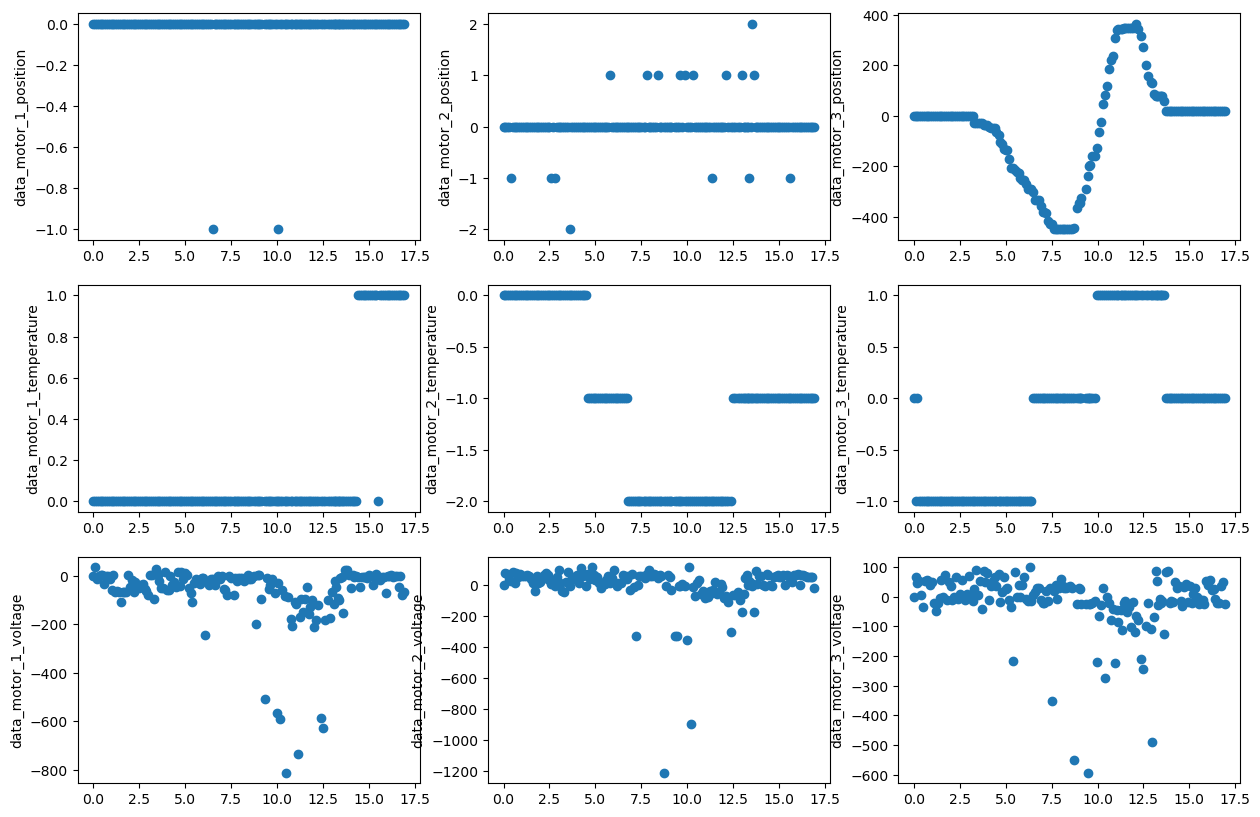

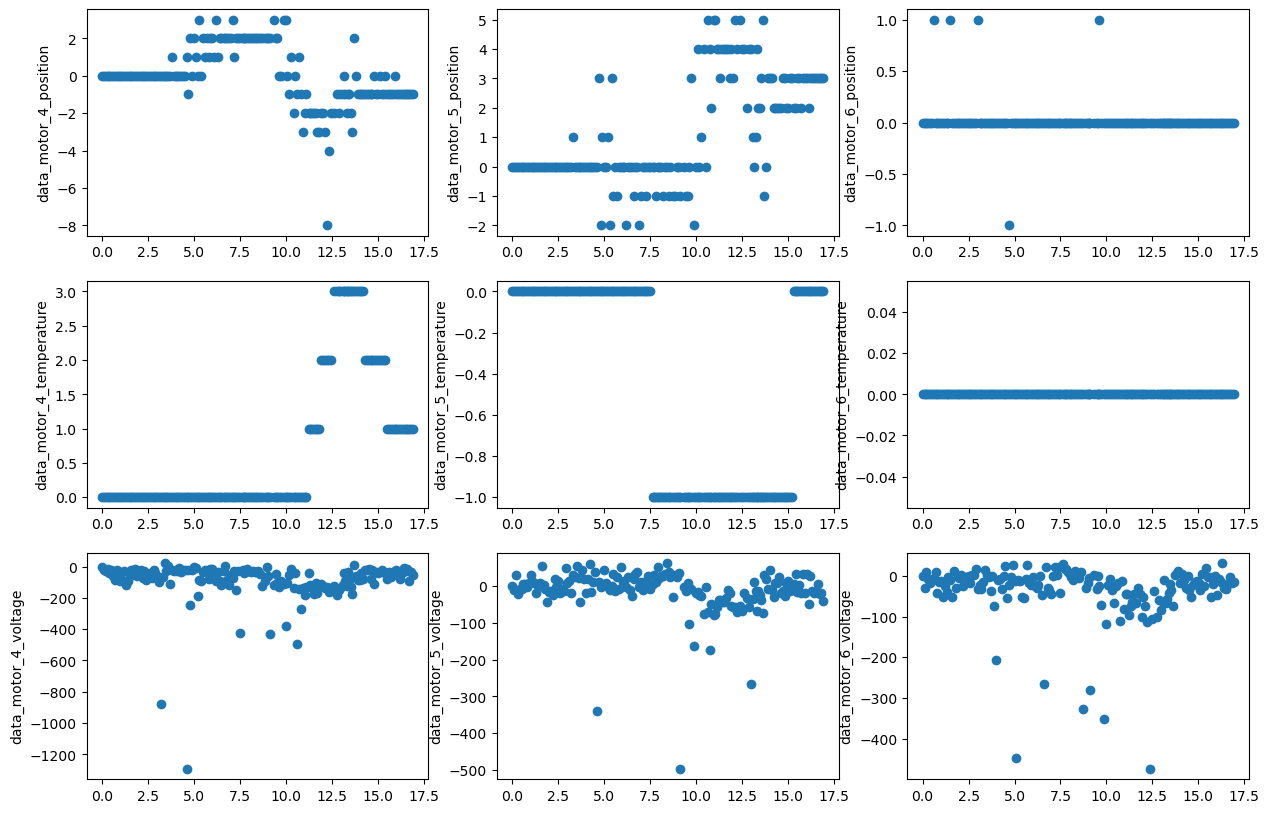

20240503_163963: 19    Pick up and place
Name: Description, dtype: object



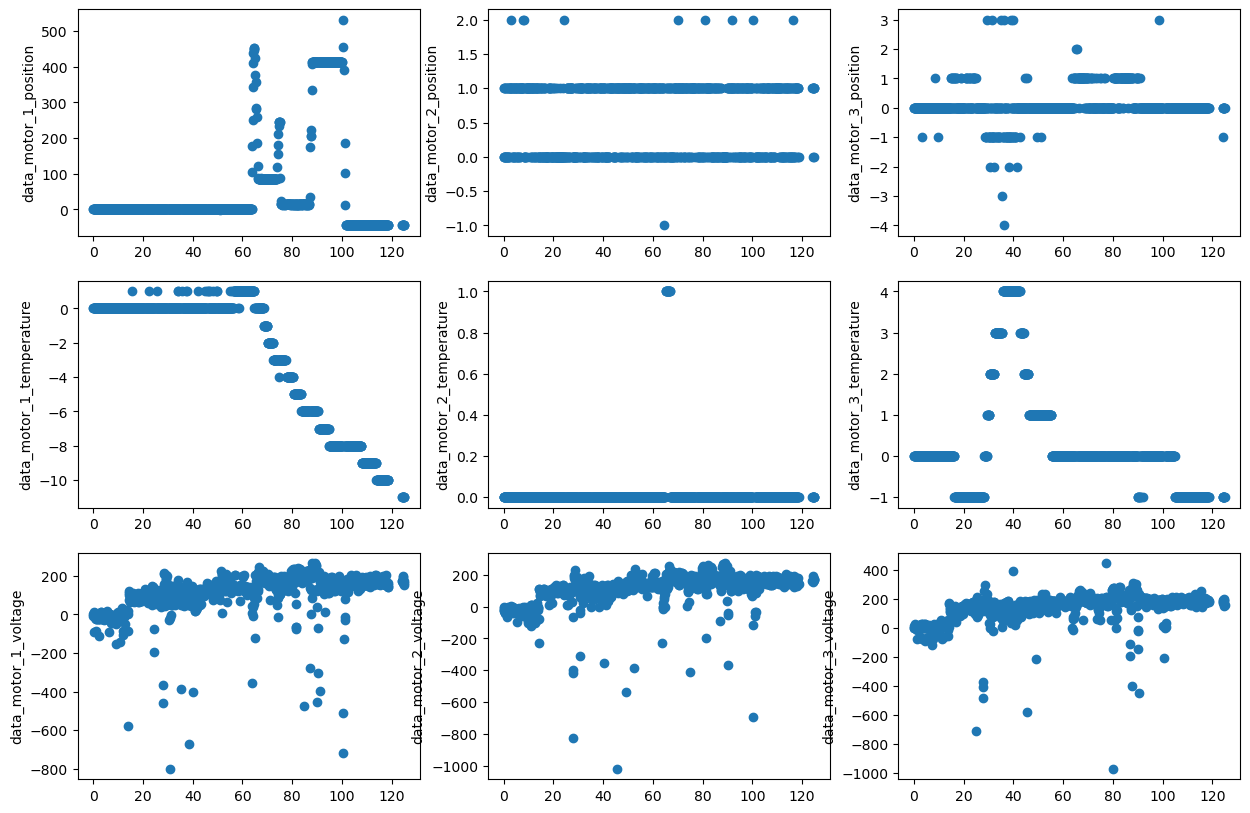

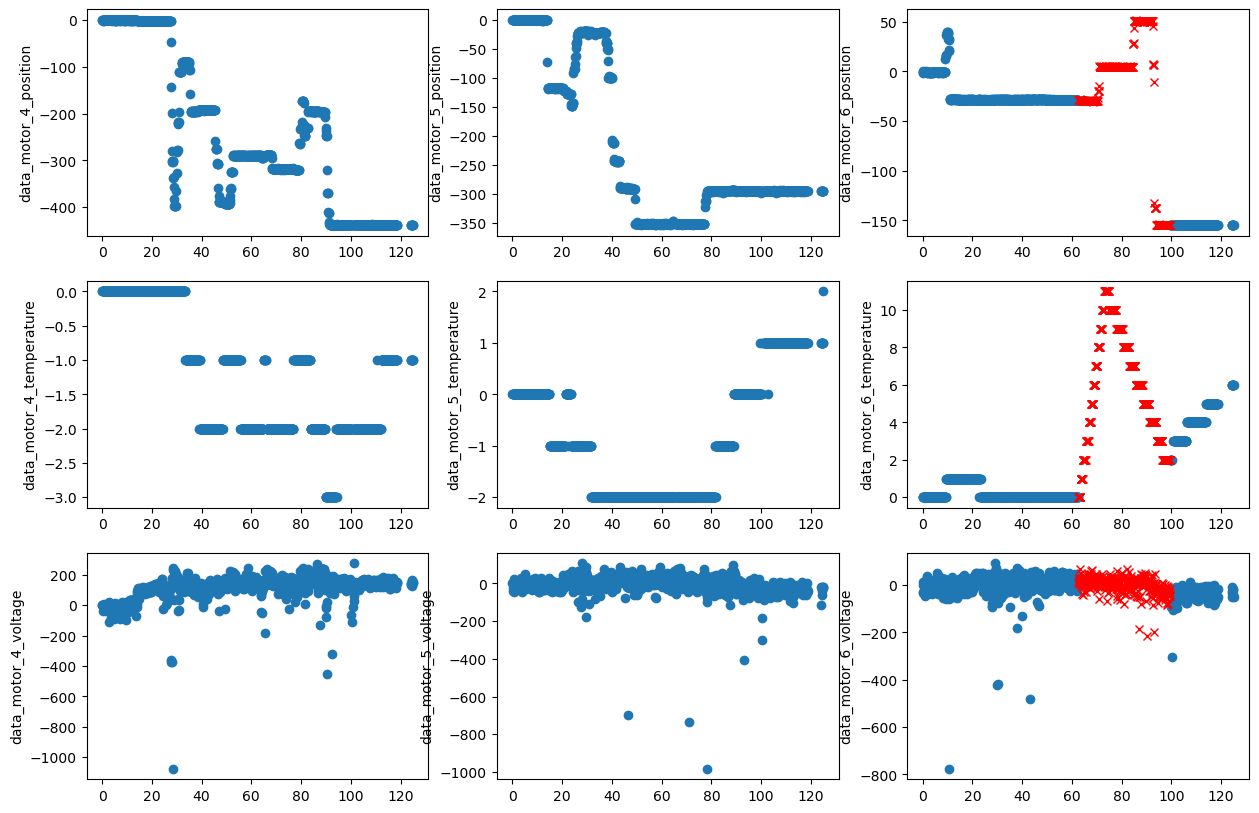

20240503_164435: 20    Turning motor 6
Name: Description, dtype: object



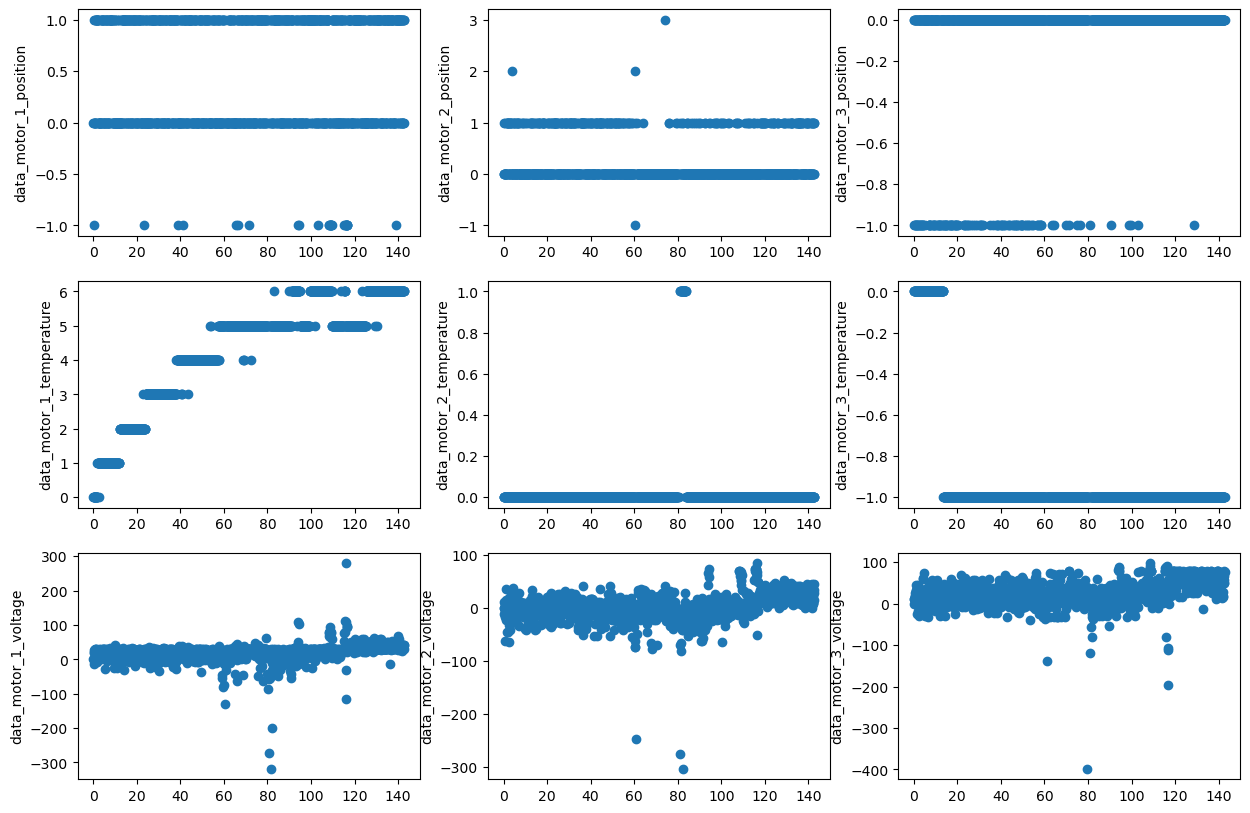

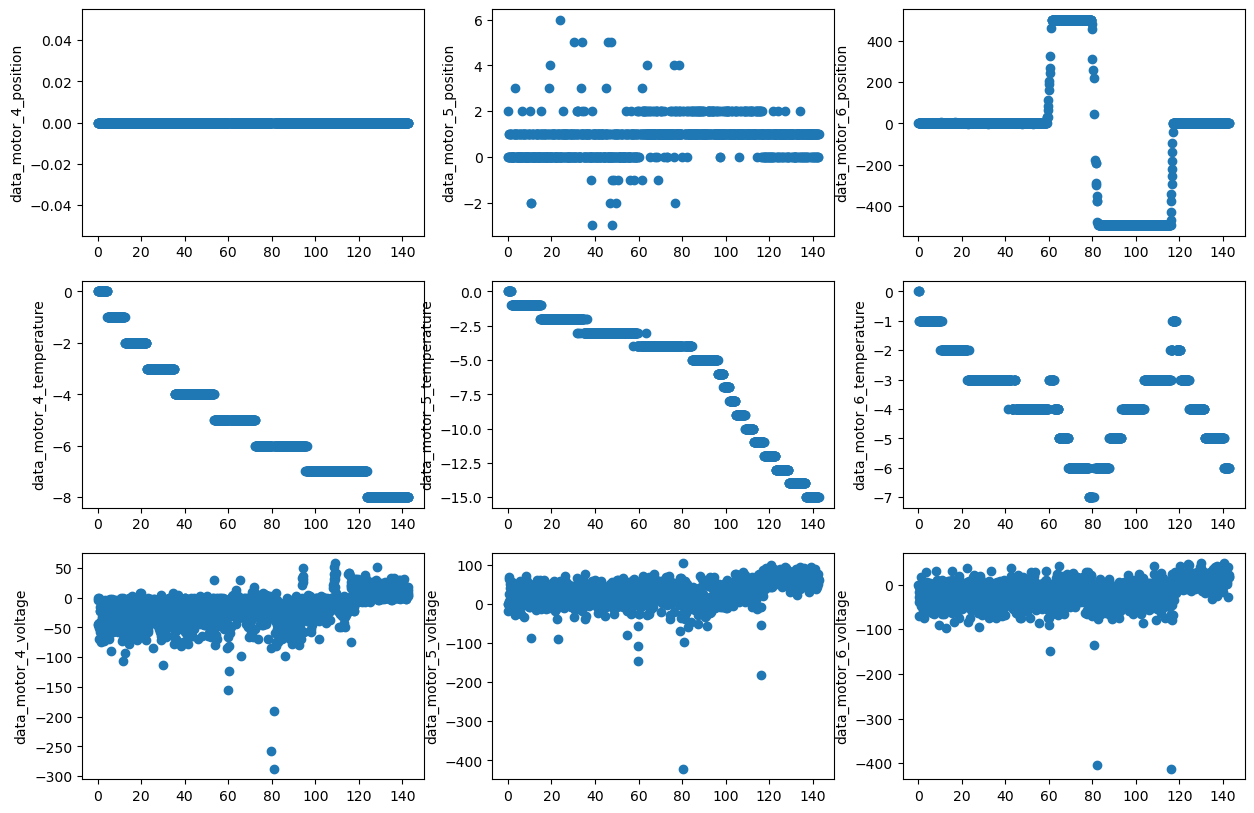

20240503_164675: 21    Turning motor 6
Name: Description, dtype: object



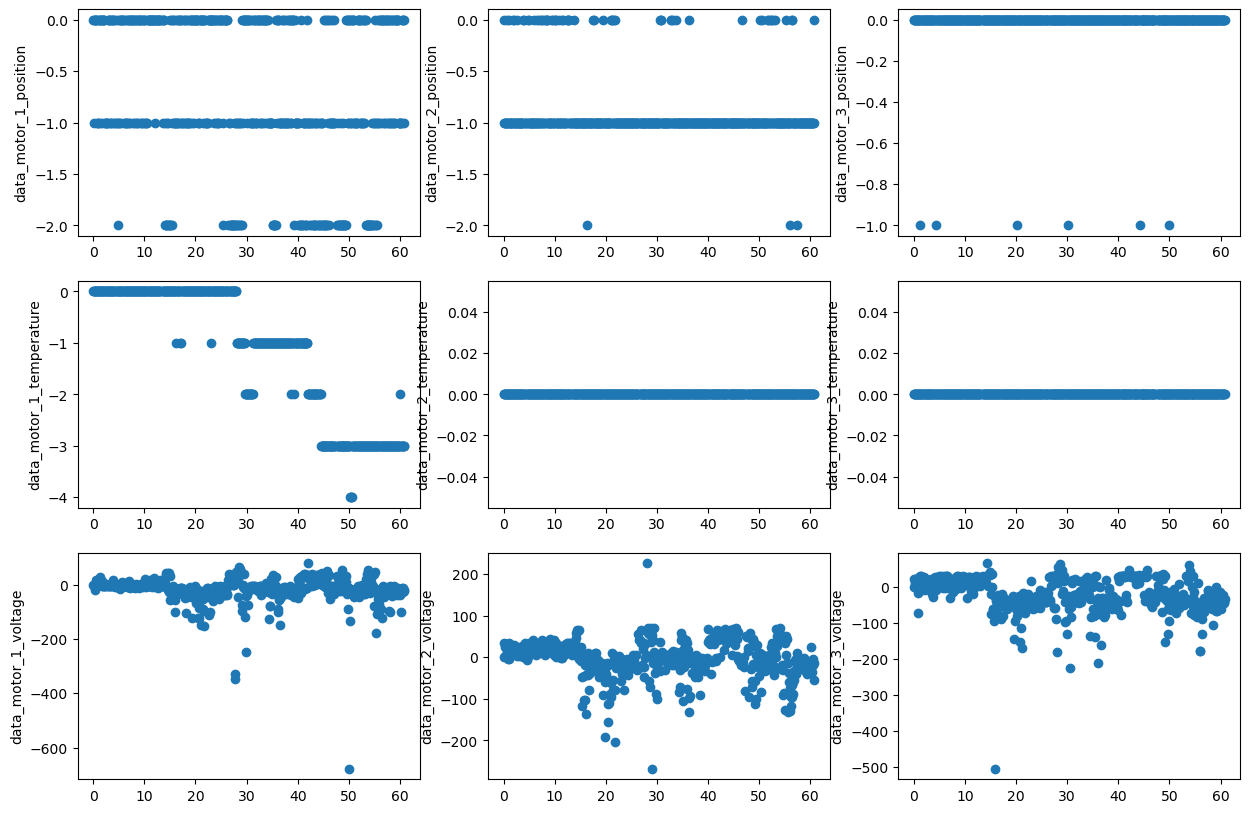

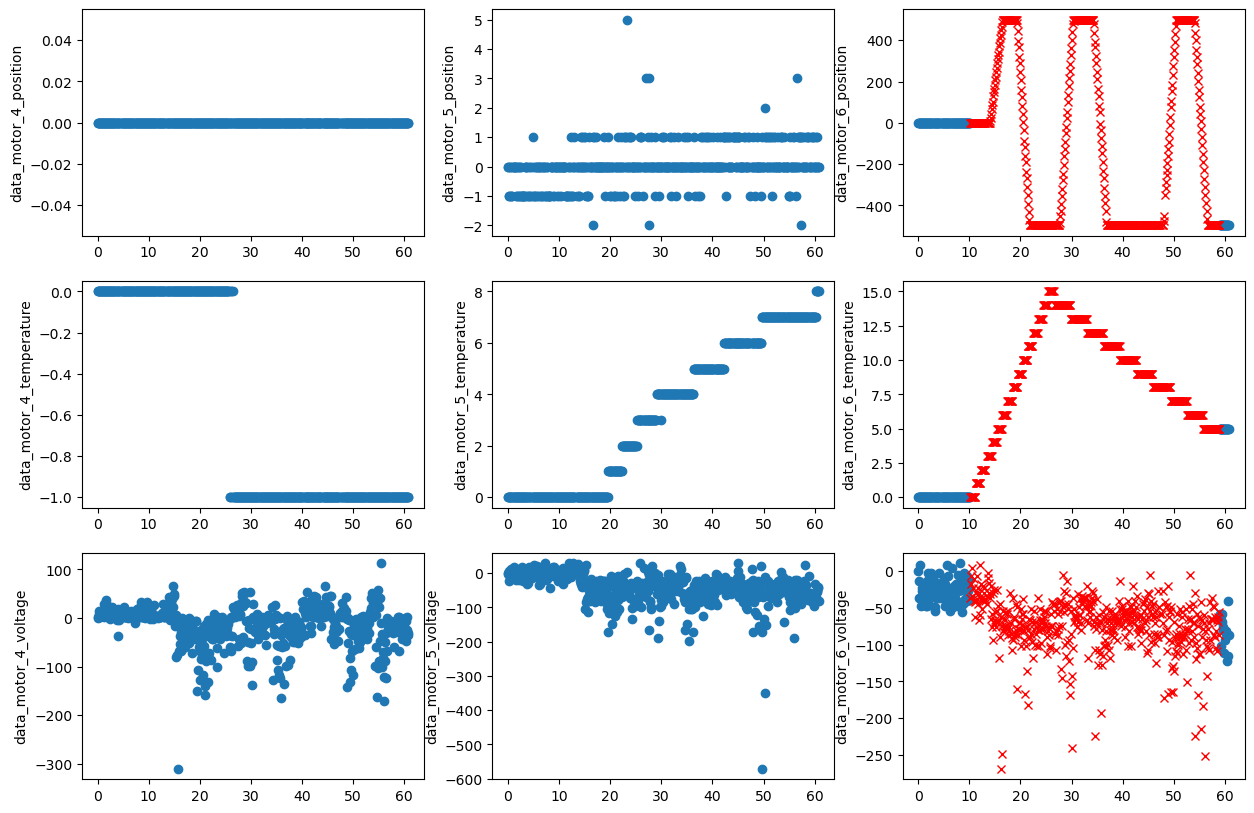

20240503_165189: 22    Turning motor 6
Name: Description, dtype: object



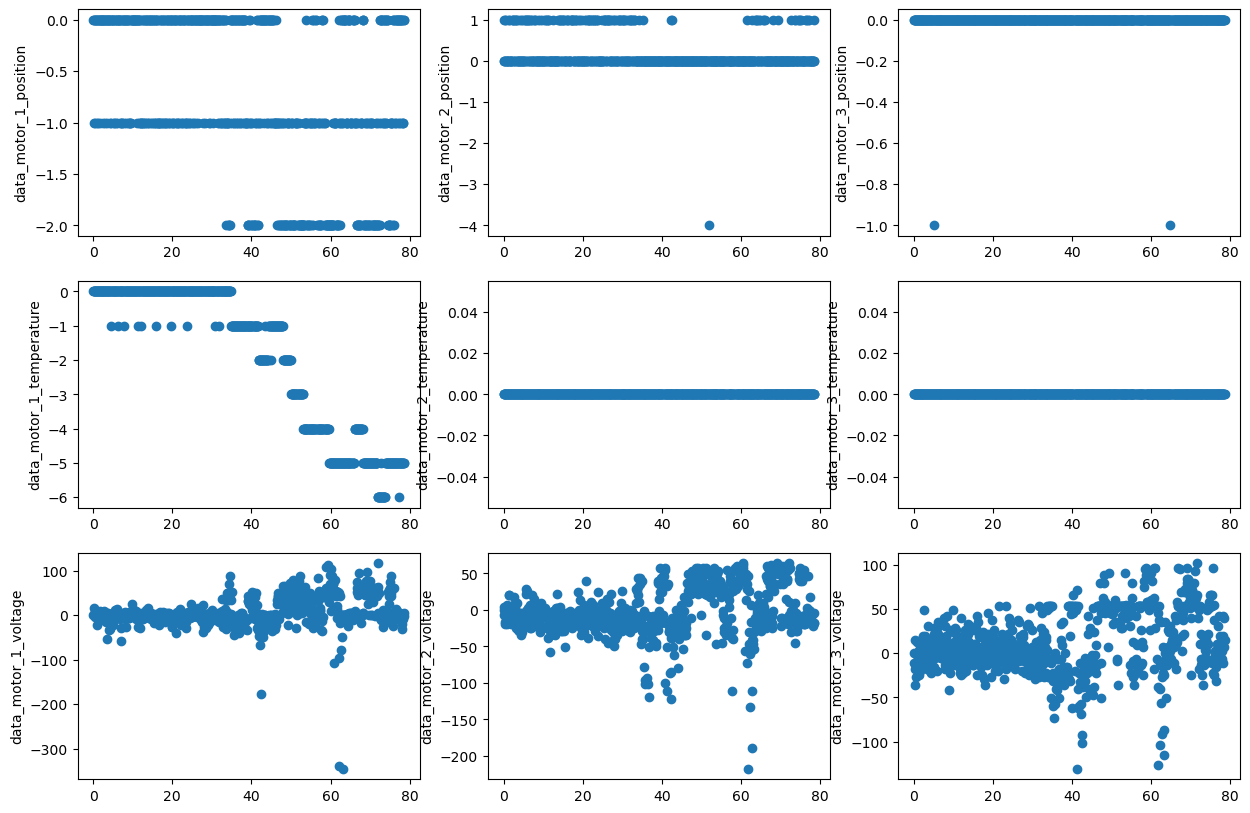

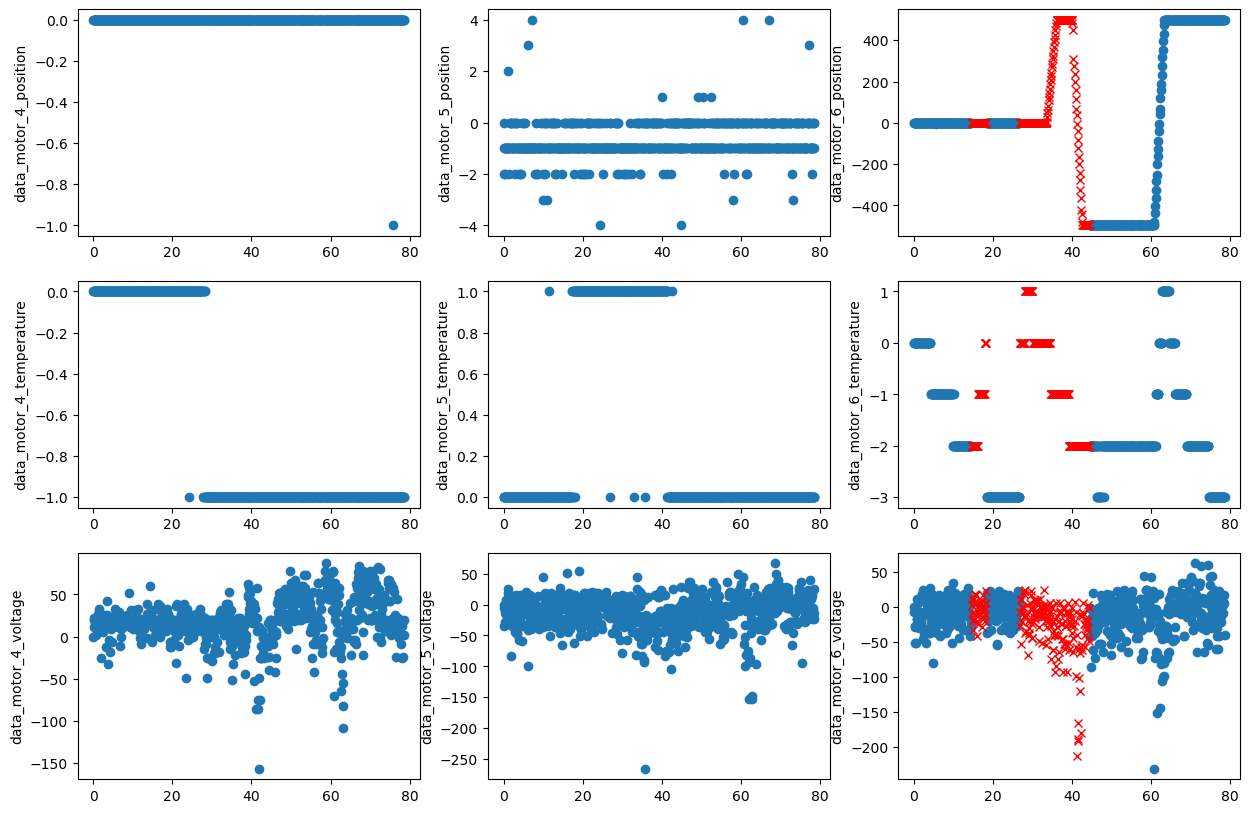

In [2]:
# Ignore warnings.
warnings.filterwarnings('ignore')

# Read all the dataset. Change to your dictionary if needed.
base_dictionary = '../../dataset/training_data/training_data/'
df_train = read_all_test_data_from_path(base_dictionary, pre_processing, is_plot=True)

### Testing data.

20240527_094865: 0    Transfer goods
Name: Description, dtype: object



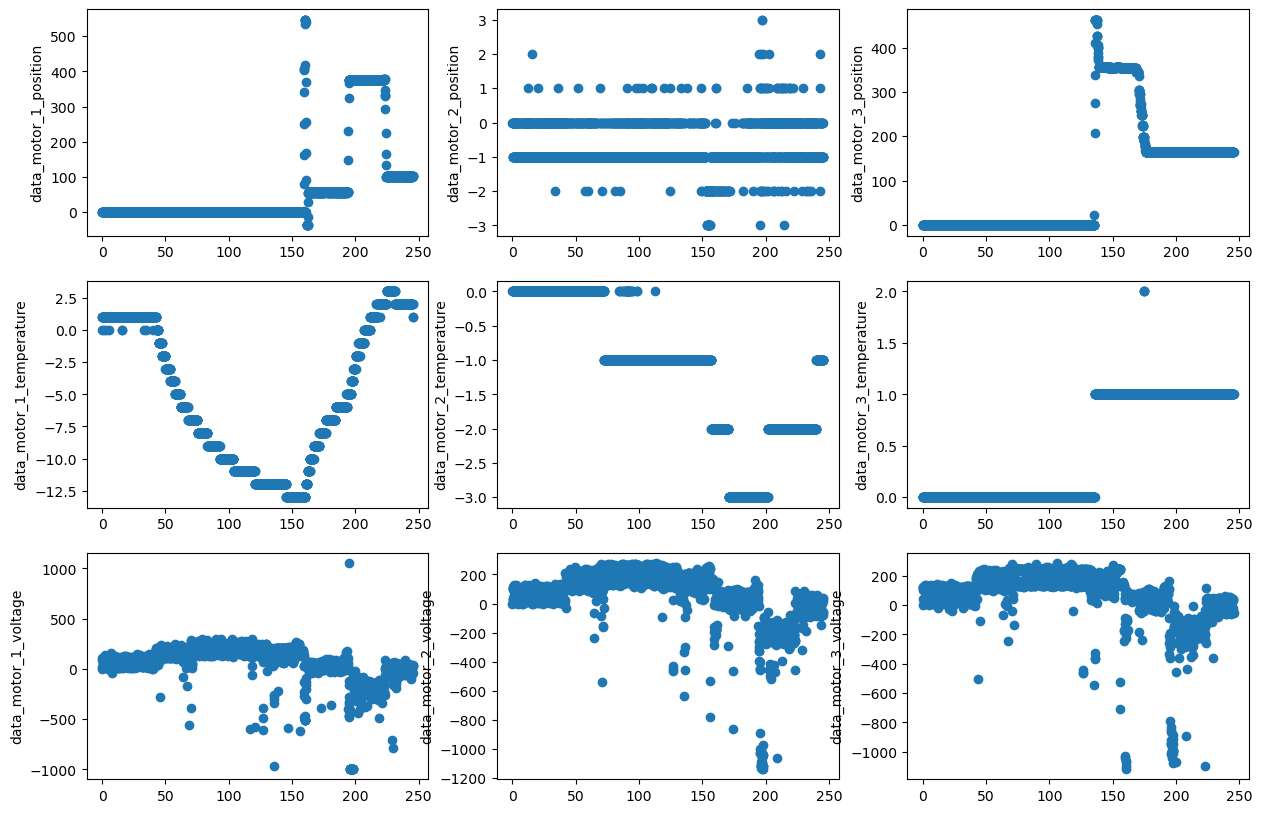

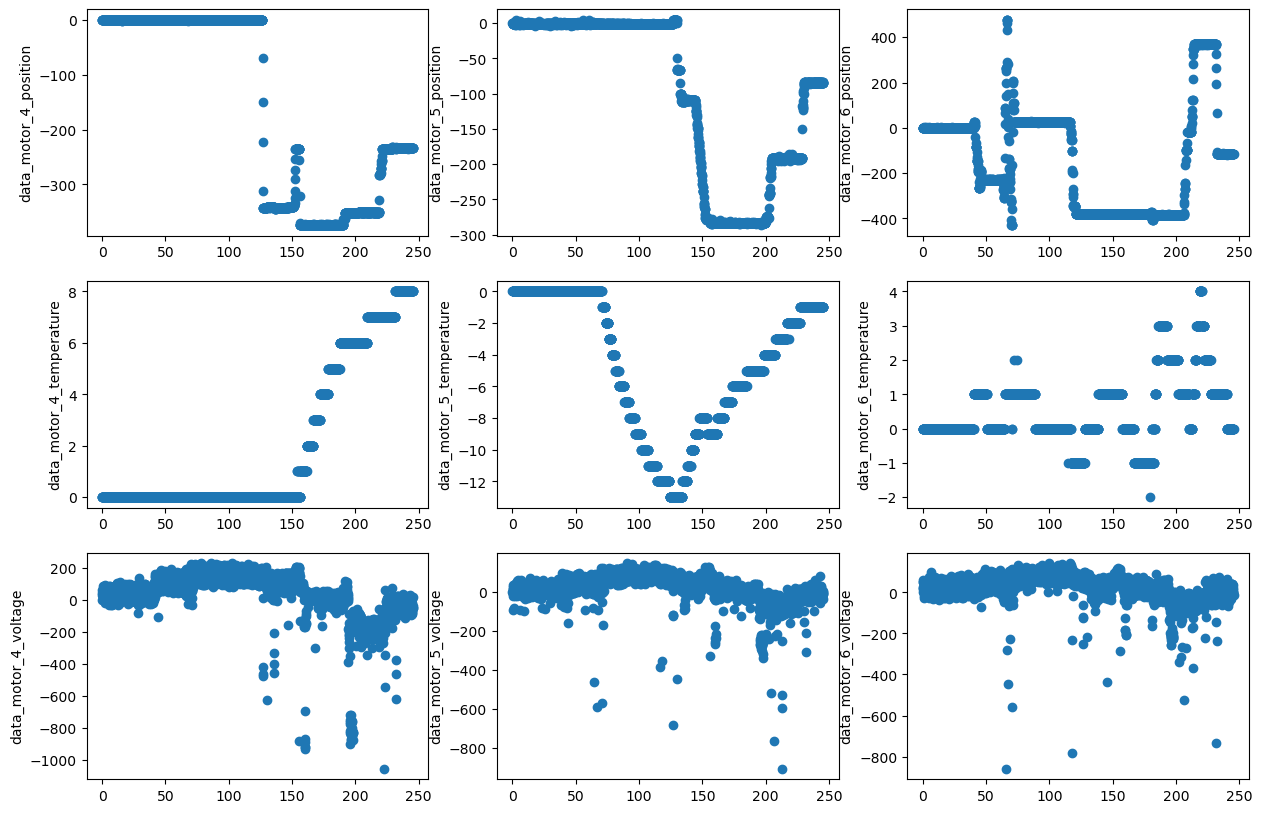

20240527_100759: 1    Transfer goods
Name: Description, dtype: object



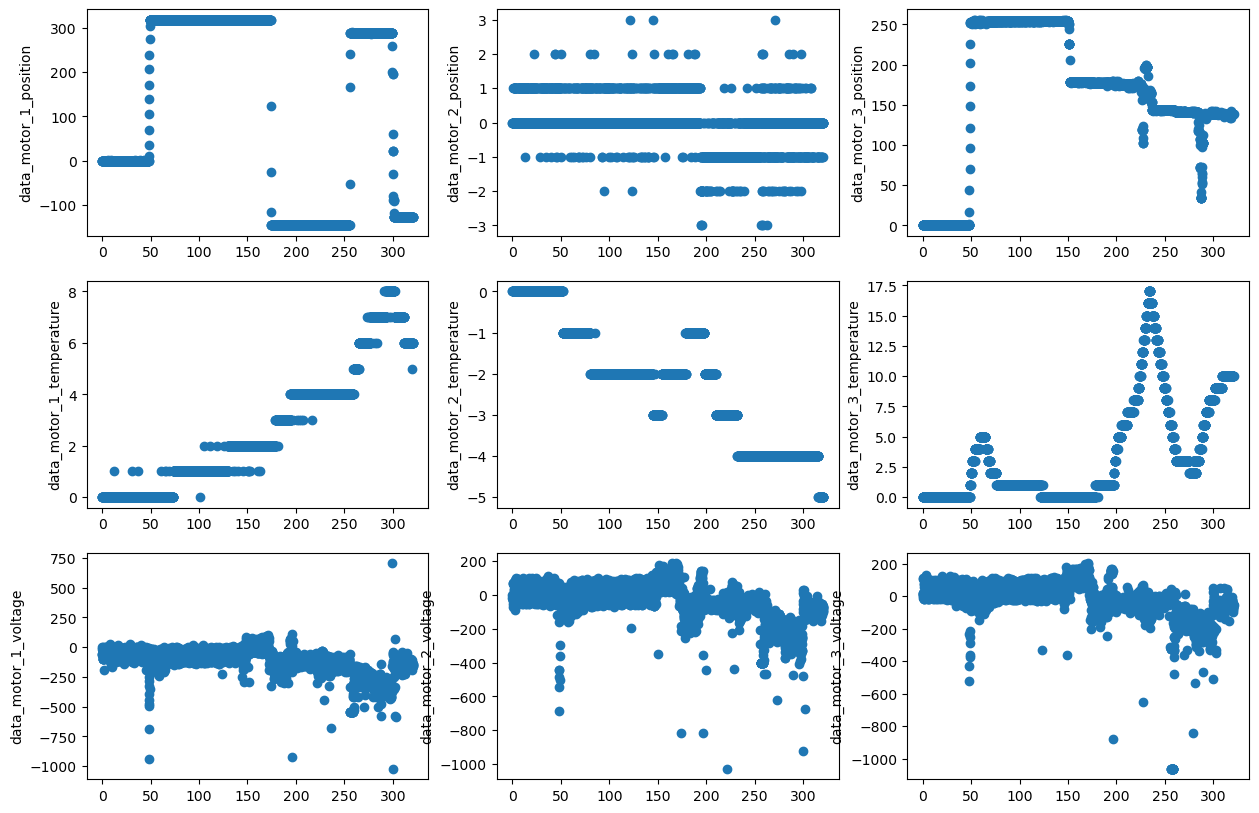

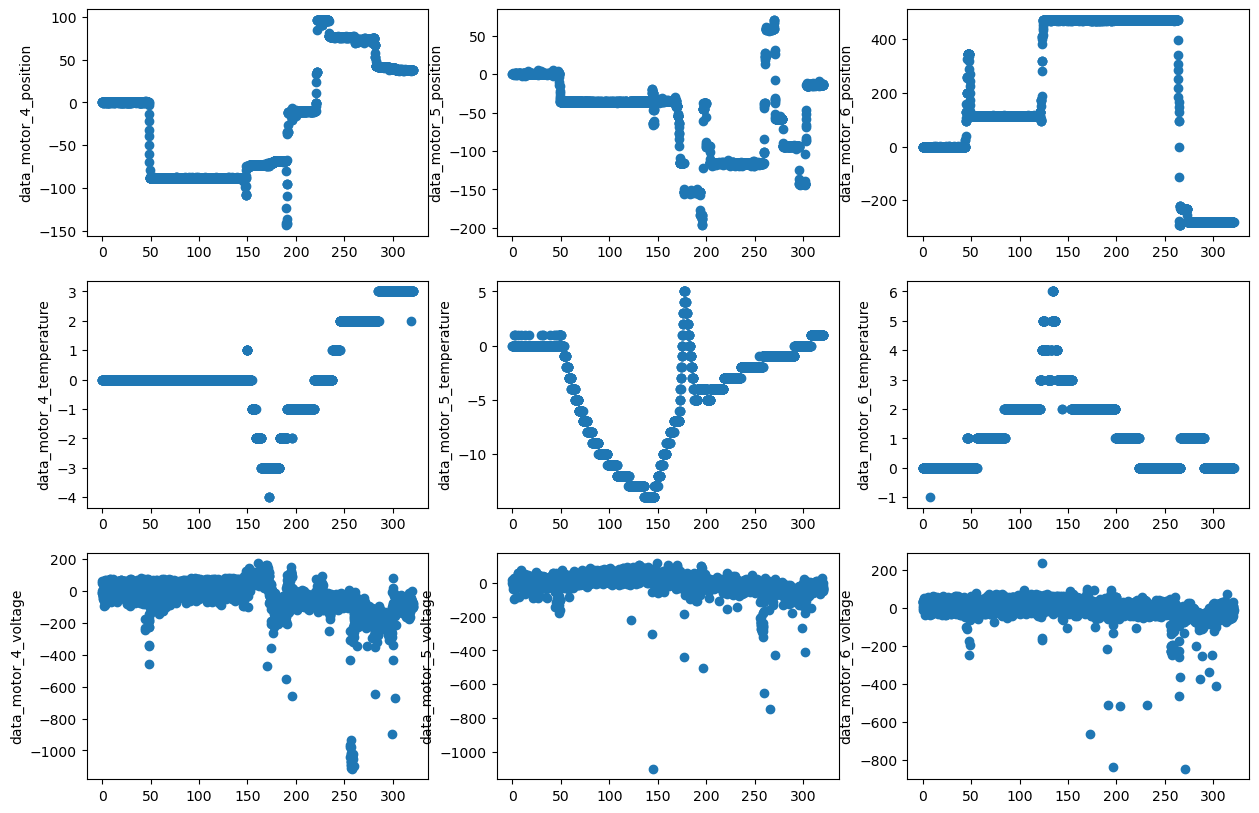

20240527_101627: 2    Transfer goods
Name: Description, dtype: object



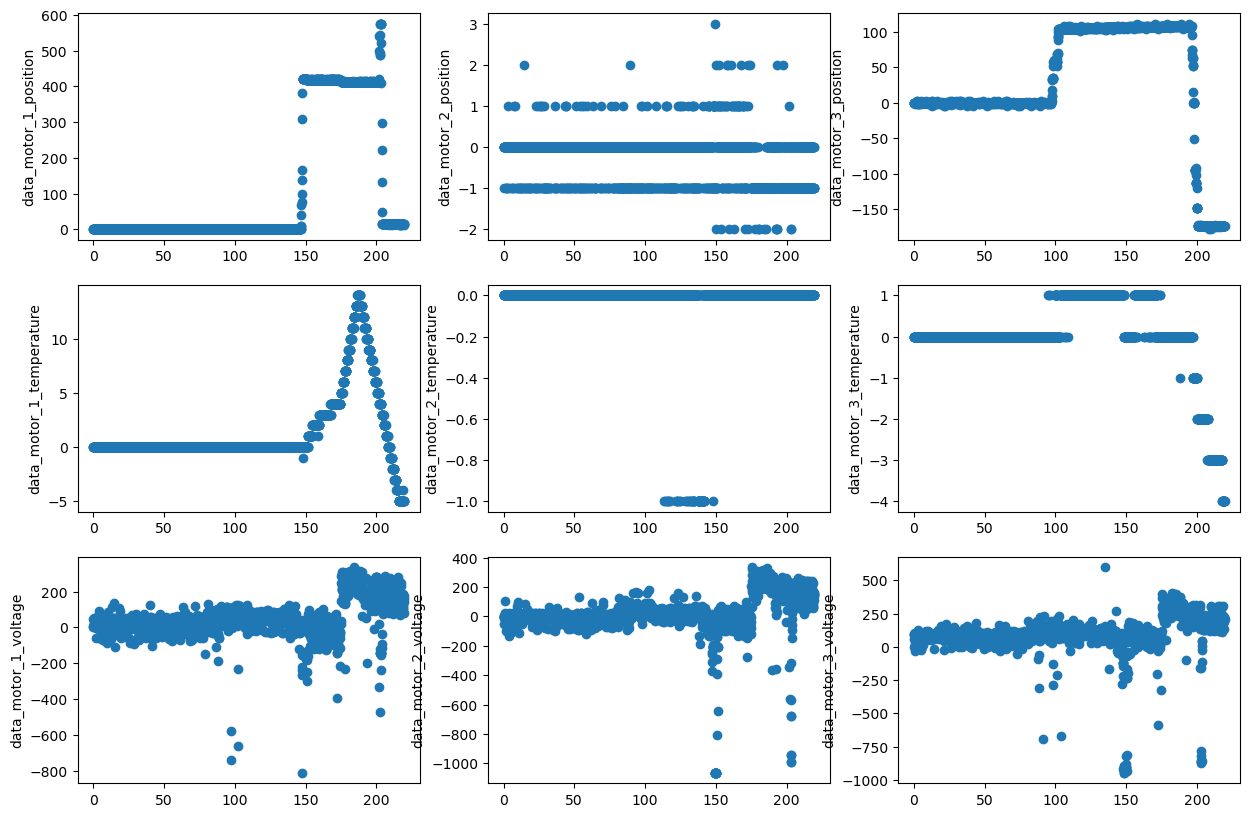

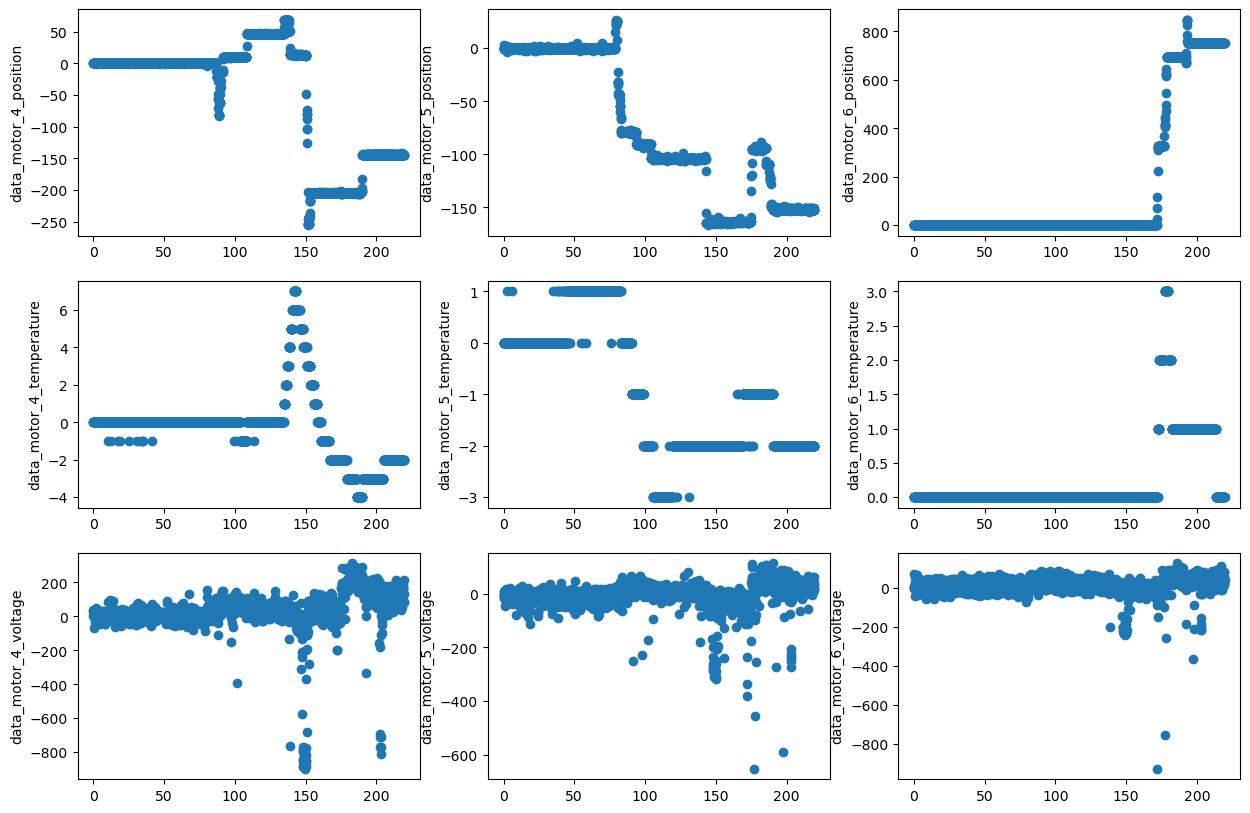

20240527_102436: 3    Not moving
Name: Description, dtype: object



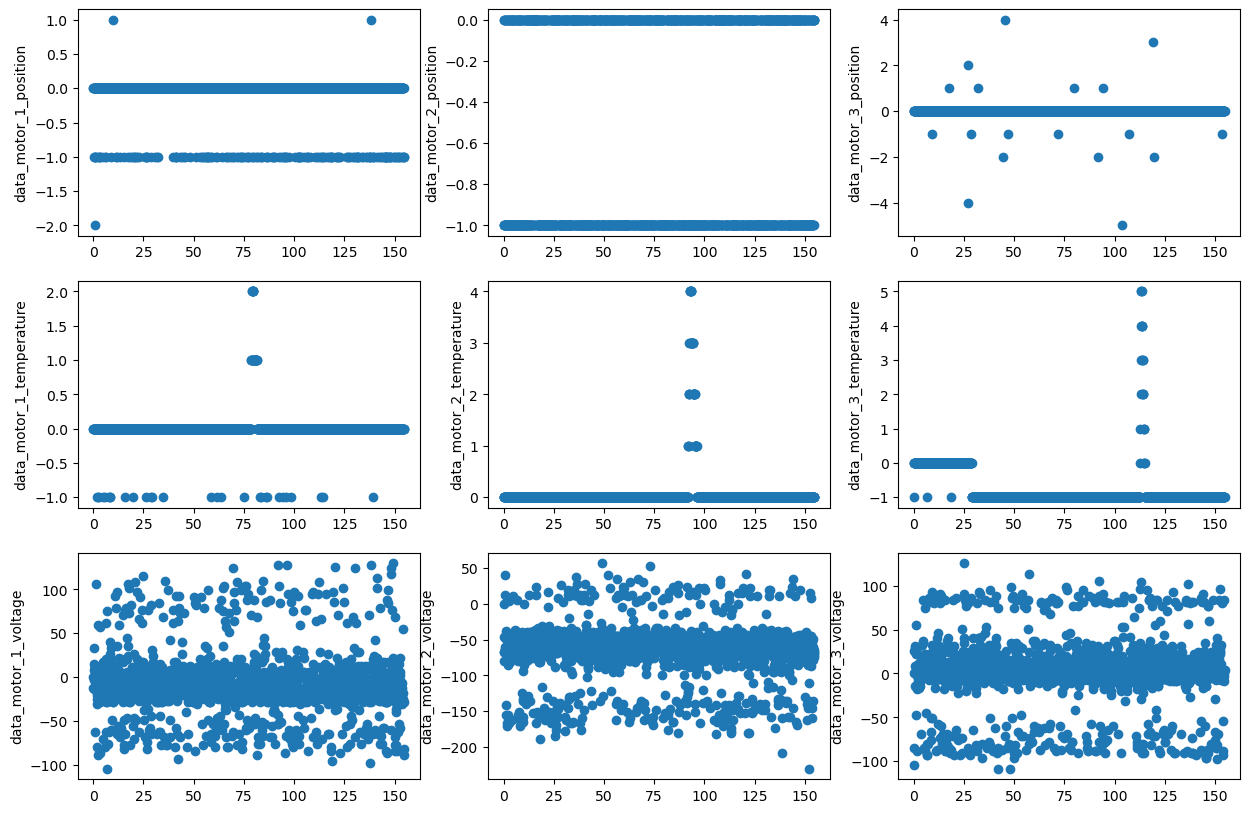

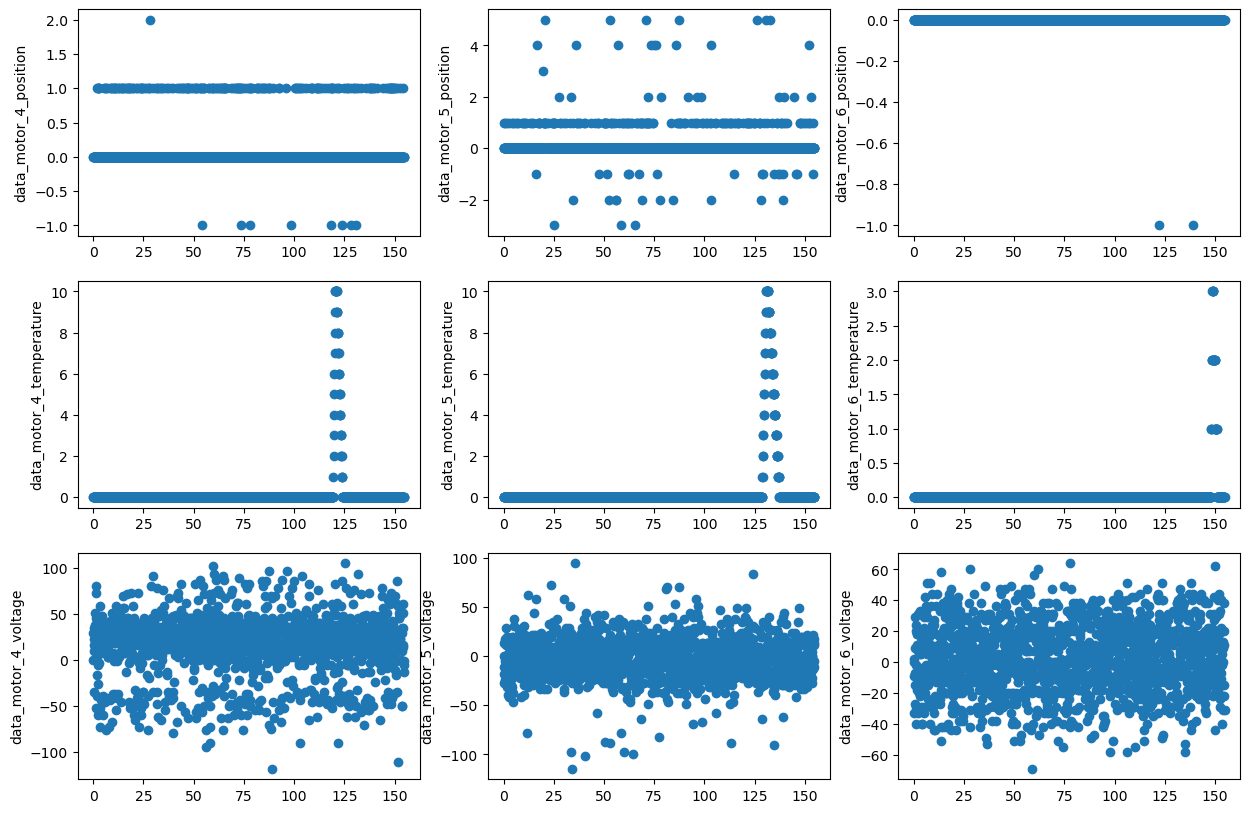

20240527_102919: 4    Not moving
Name: Description, dtype: object



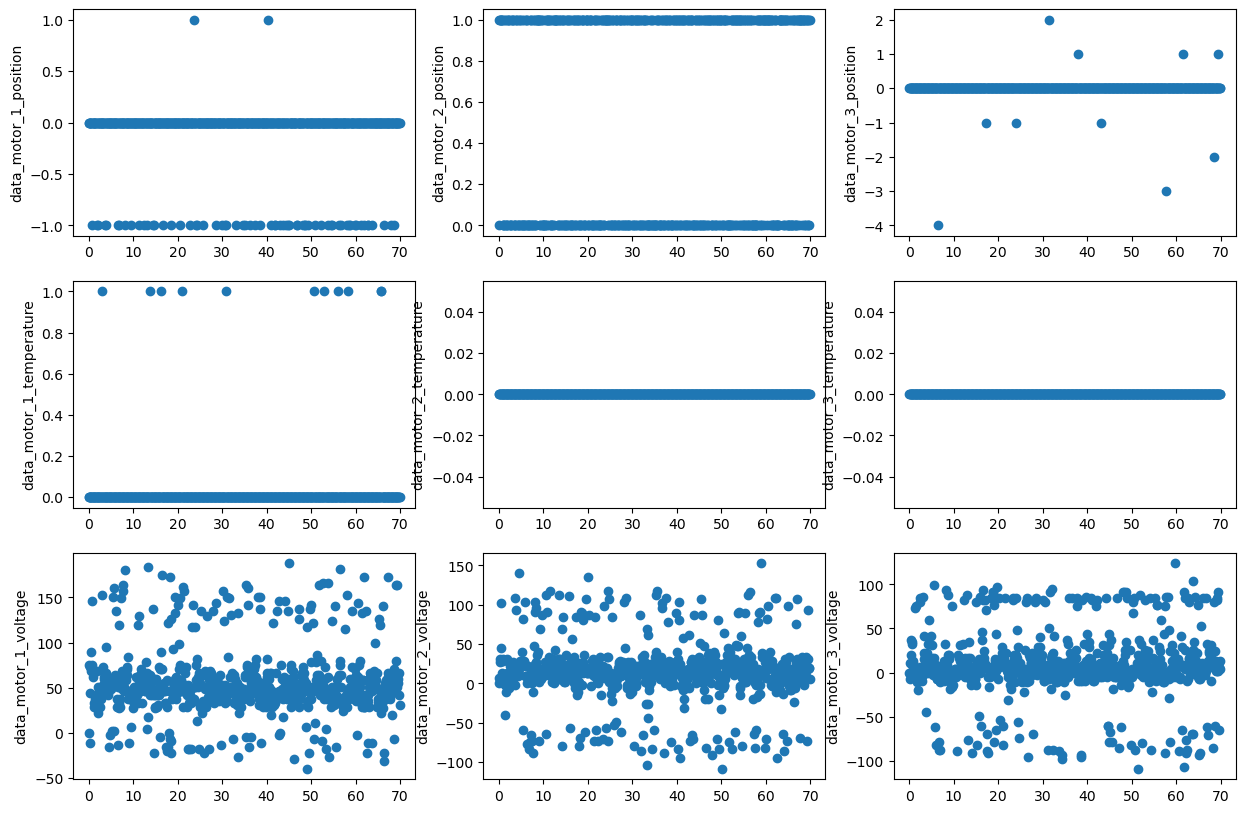

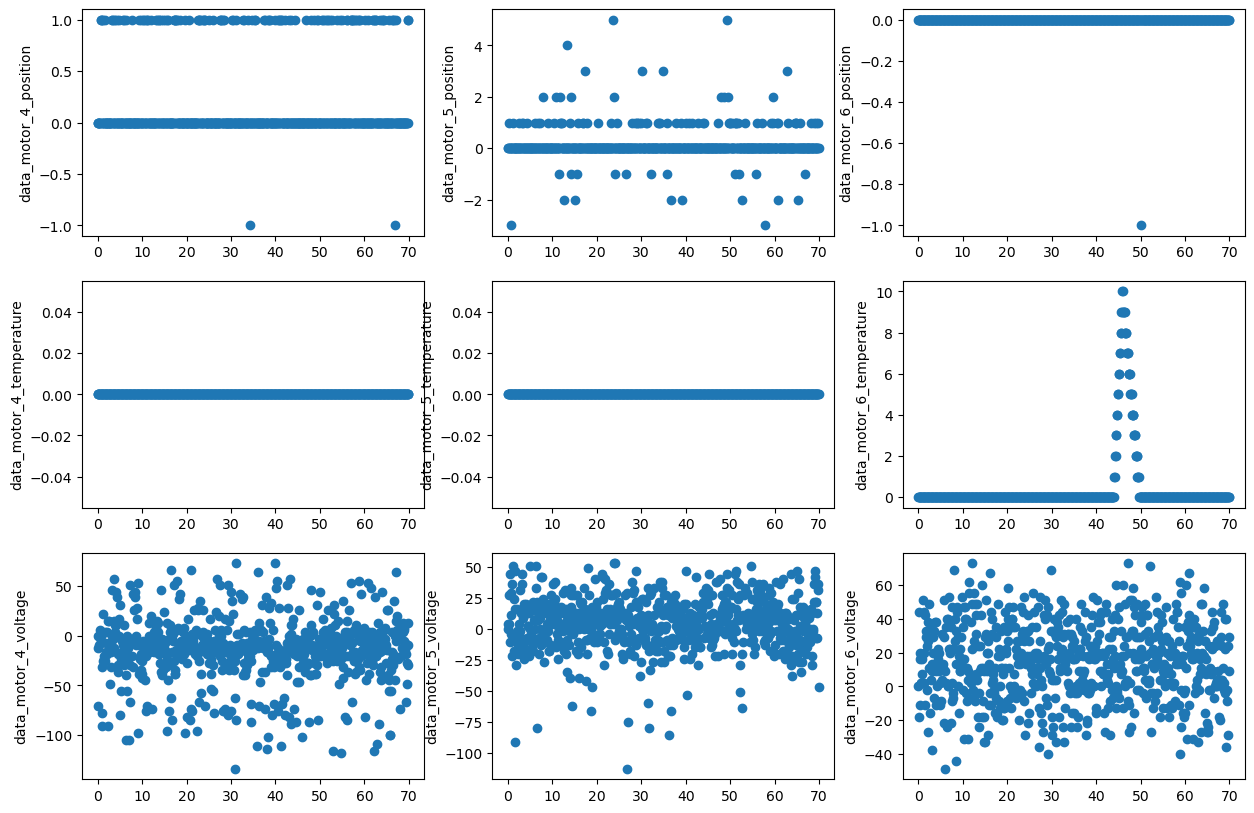

20240527_103311: 5    Not moving
Name: Description, dtype: object



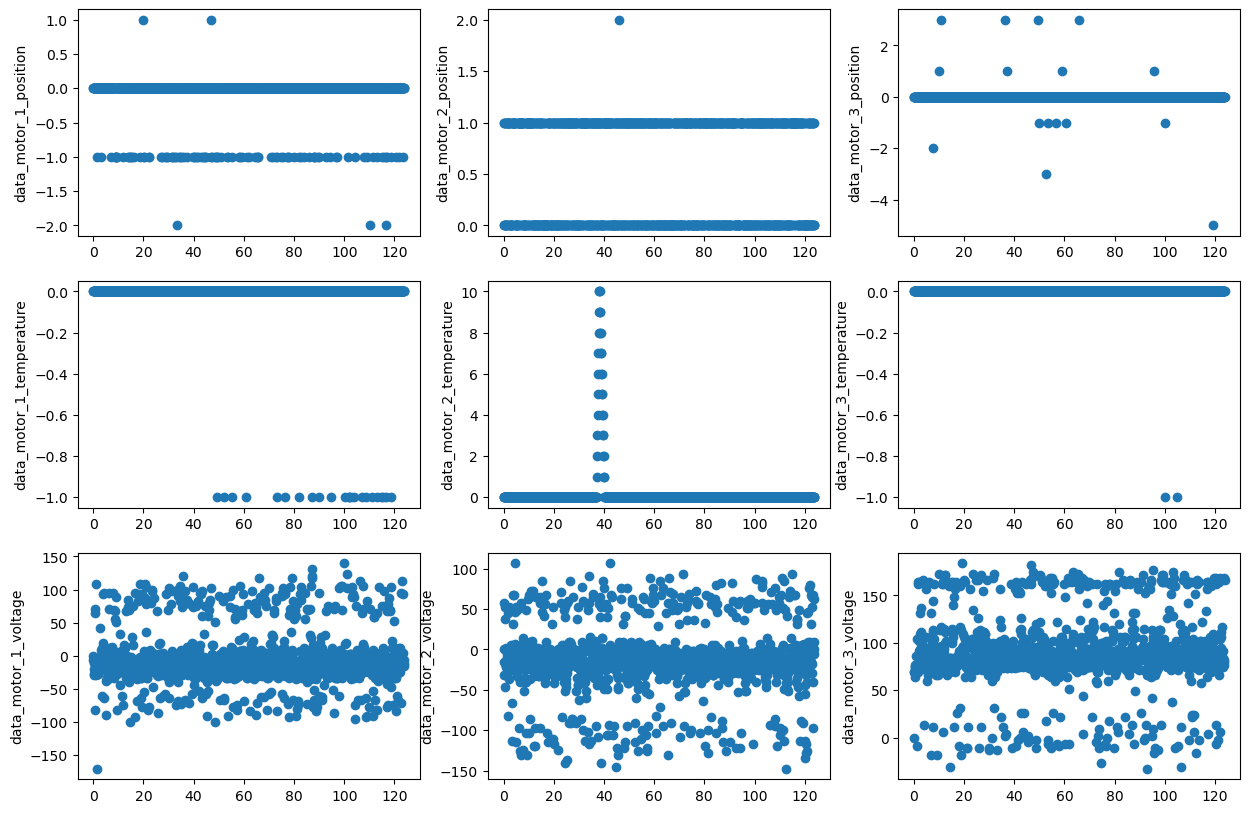

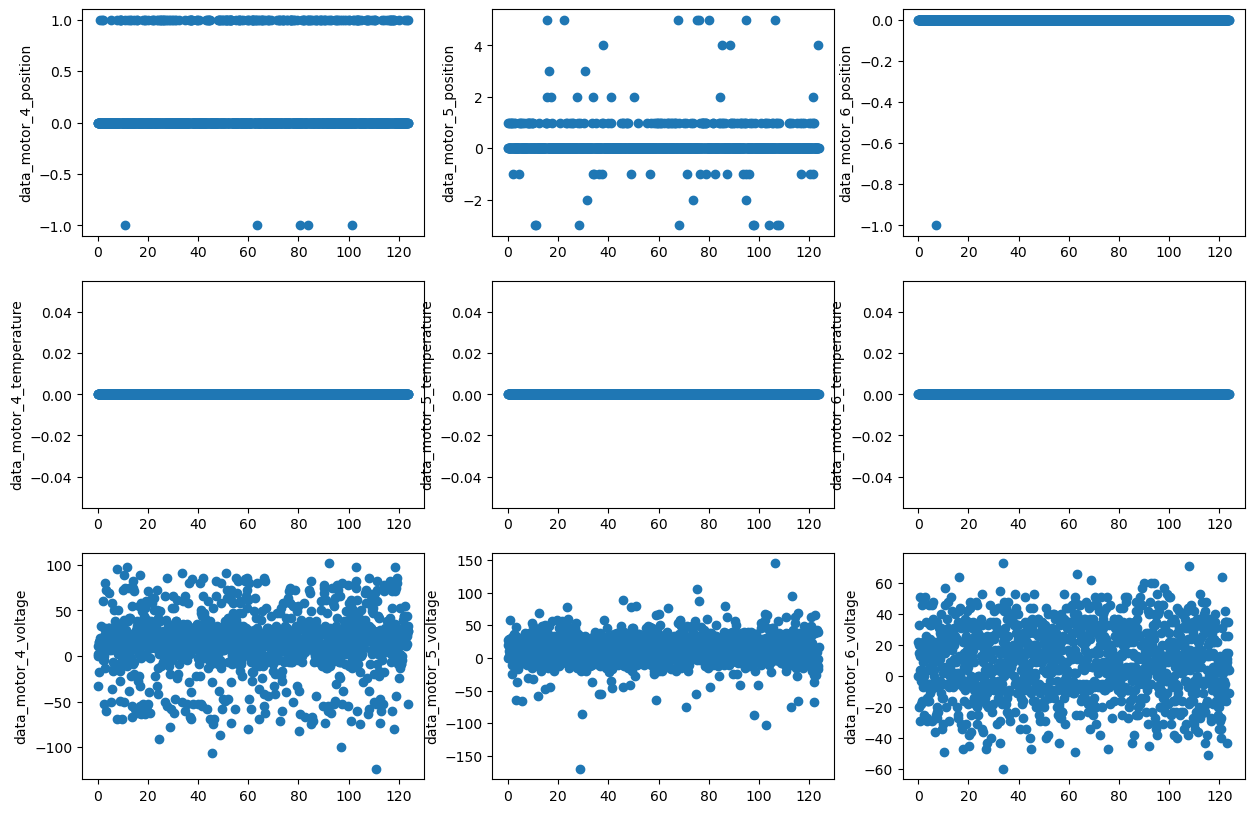

20240527_103690: 6    Moving one motor
Name: Description, dtype: object



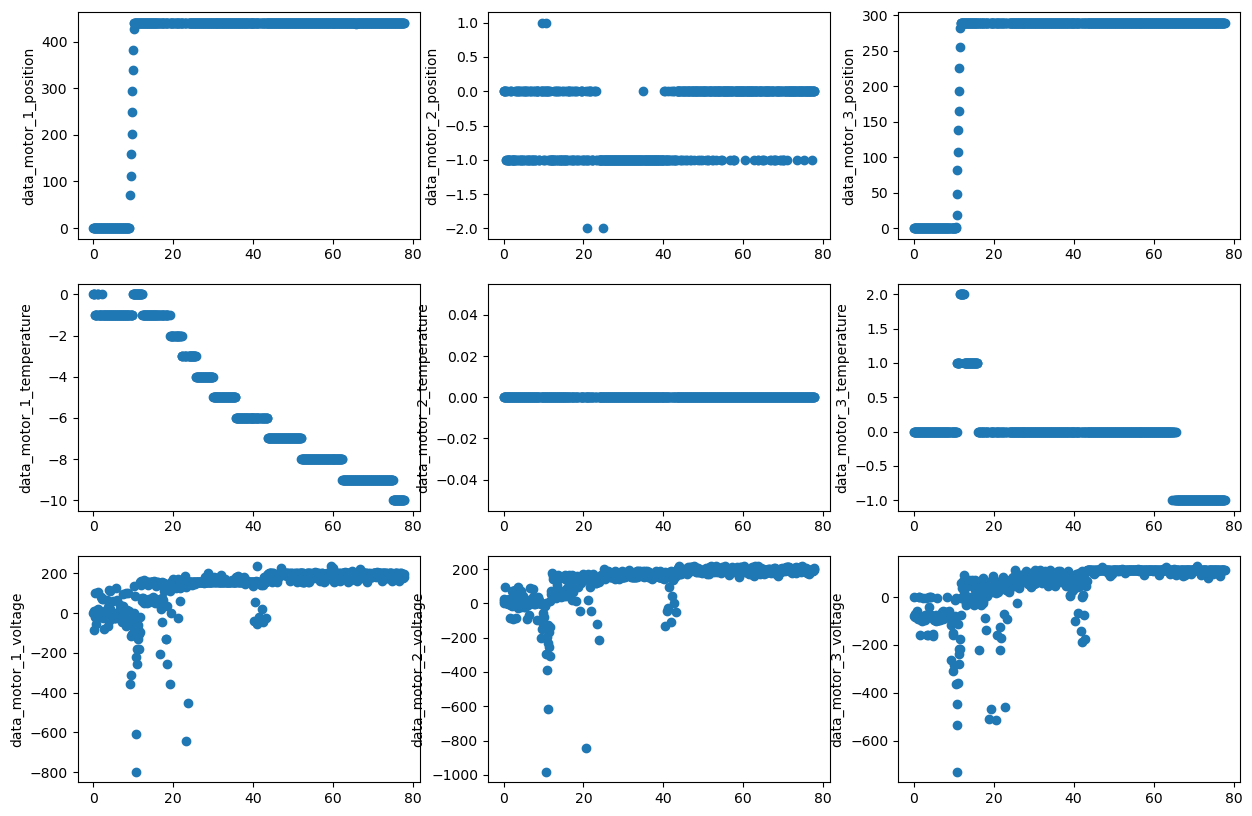

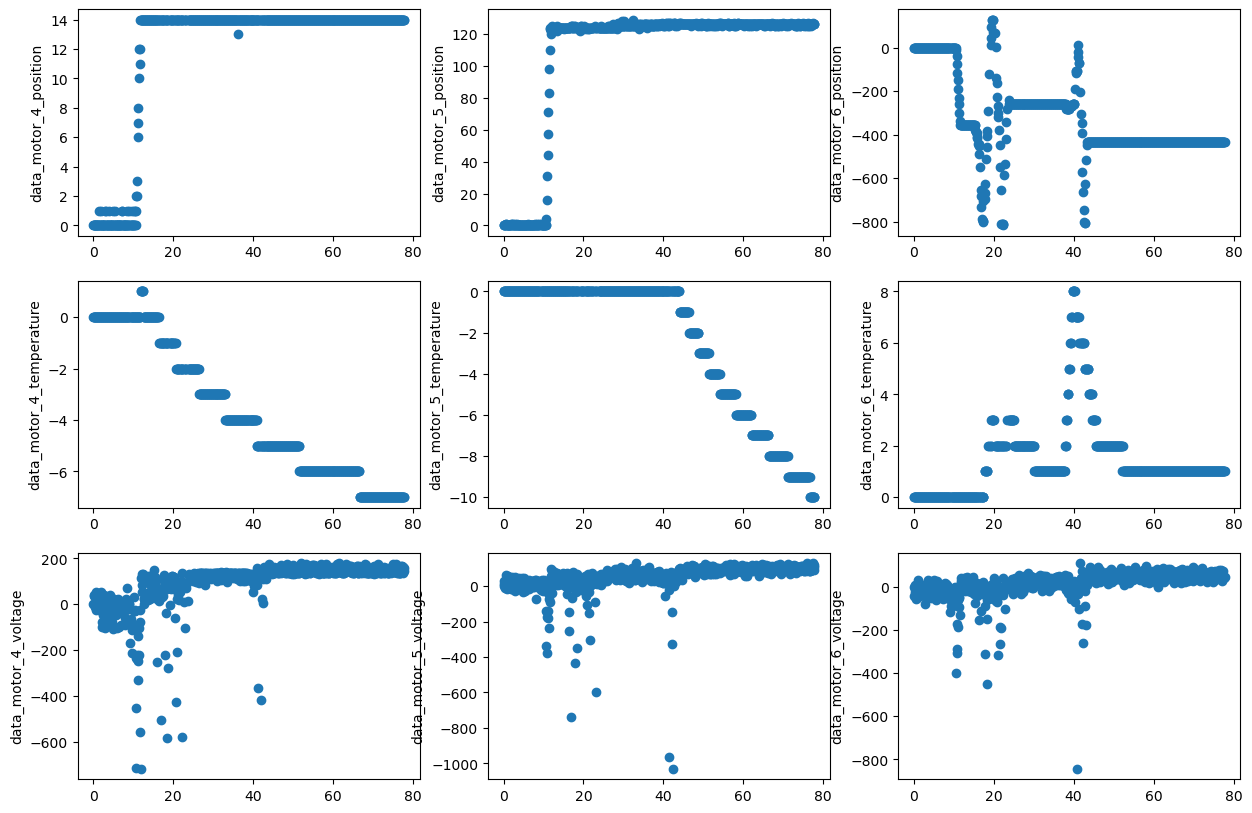

20240527_104247: 7    Moving one motor
Name: Description, dtype: object



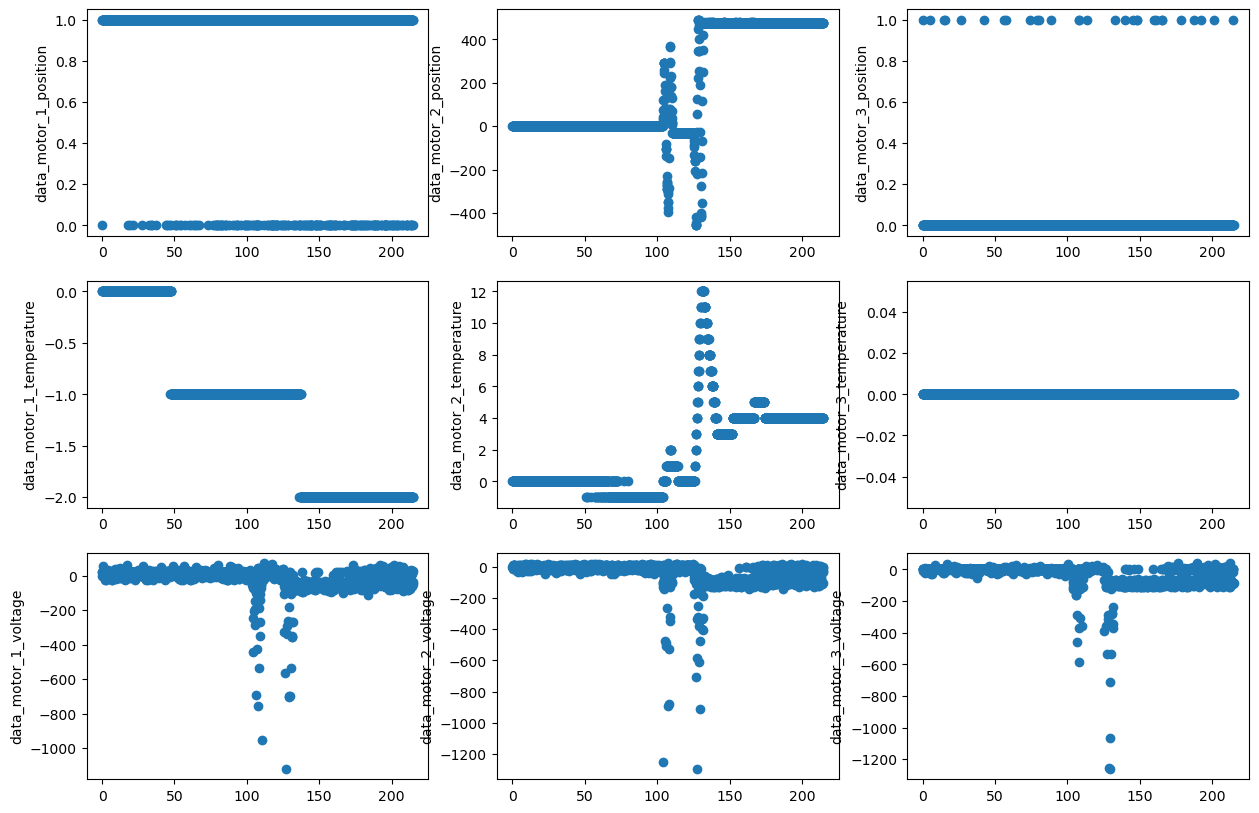

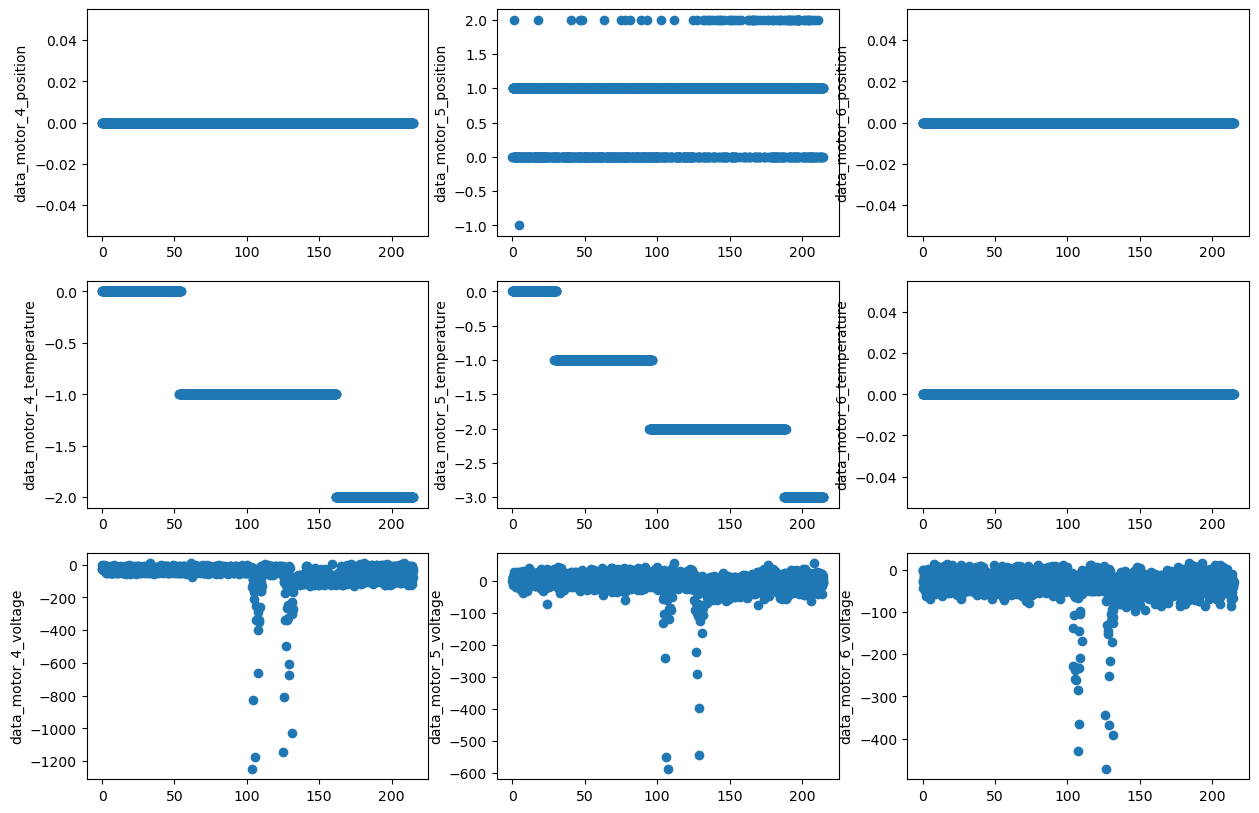

In [3]:
# Read all the dataset. Change to your dictionary if needed.
base_dictionary = '../../dataset/testing_data/testing_data/'
df_test = read_all_test_data_from_path(base_dictionary, pre_processing, is_plot=True)

## Demo: Apply a classification-based fault detection model.

In this section, we use motor $6$ as an example to demonstrate how to train a classification-based fault detection model and apply it to predict the labels on the testing dataset. The basic steps are the same as Workpackage 2. However, you need to pay attention if you use sliding windows to augument the feature space. In this case, the first window_size points in each sequence were scaped in the augumented feature space, as we do not have enough points in the history. In the data challenge, these scaped points need to be predicted manually, as the evaluation is done on all the points, including the scaped points.

In the current version of `prepare_sliding_window`, we addressed this issue by filling the missed history based on the closest available observations in the dataset. Therefore, you just need to make sure you use this version of `utility.py`, the scaped points will be filled automatically.

Below, you can find a demo how to train a logistic regression model to predict the labels for motor 6. For more details on the classification-bsaed fault detection models, you can have a look at the tutorials in [WP2](../../supporting_scripts/WP_2_20240516/demo_motor_6_lr.ipynb).

### Training

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from utility import extract_selected_feature, prepare_sliding_window

# Define the motor index.
motor_idx = 1

# Specify the test conditions you would like to include in the training.
df_data_experiment = df_train[df_train['test_condition'].isin(['20240425_093699', '20240425_094425', '20240426_140055',
                                                       '20240503_164675', '20240503_165189',
                                                       '20240503_163963', '20240325_155003'])]

# Define the features.
feature_list_all = ['time', 'data_motor_1_position', 'data_motor_1_temperature', 'data_motor_1_voltage',
                    'data_motor_2_position', 'data_motor_2_temperature', 'data_motor_2_voltage',
                    'data_motor_3_position', 'data_motor_3_temperature', 'data_motor_3_voltage',
                    'data_motor_4_position', 'data_motor_4_temperature', 'data_motor_4_voltage',
                    'data_motor_5_position', 'data_motor_5_temperature', 'data_motor_5_voltage',
                    'data_motor_6_position', 'data_motor_6_temperature', 'data_motor_6_voltage']
# Extract the features.
df_tr_x, df_tr_y = extract_selected_feature(df_data_experiment, feature_list_all, motor_idx, mdl_type='clf')

# Prepare the training data based on the defined sliding window.
window_size = 50
sample_step = 10
X_train, y_train = prepare_sliding_window(df_x=df_tr_x, y=df_tr_y, window_size=window_size, sample_step=sample_step, mdl_type='clf')


models = {
    'LogisticRegression': {
        'model': LogisticRegression(class_weight='balanced', max_iter=1000),
        'params': {'mdl__C': [0.01, 0.1, 1, 10]}
    },
    'RandomForest': {
        'model': RandomForestClassifier(class_weight='balanced'),
        'params': {'mdl__n_estimators': [50, 100], 'mdl__max_depth': [5, 10]}
    },
    'SVM': {
        'model': SVC(class_weight='balanced'),
        'params': {'mdl__C': [0.1, 1, 10], 'mdl__kernel': ['linear', 'rbf']}
    },
    'GradientBoosting': {
        'model': GradientBoostingClassifier(),
        'params': {'mdl__n_estimators': [50, 100], 'mdl__learning_rate': [0.01, 0.1]}
    },
    'KNN': {
        'model': KNeighborsClassifier(),
        'params': {'mdl__n_neighbors': [3, 5, 7]}
    },
    'NaiveBayes': {
        'model': GaussianNB(),
        'params': {} 
    }
}

best_models = {}
for name, config in models.items():
    pipeline = Pipeline([
        ('standardizer', StandardScaler()),
        ('mdl', config['model'])
    ])
    
    grid = GridSearchCV(pipeline, config['params'], scoring='f1', cv=5, n_jobs=-1)
    grid.fit(X_train, y_train)
    
    best_models[name] = grid
    print(f" {name} - Best F1: {grid.best_score_:.4f}, Params: {grid.best_params_}")

final_model_name = max(best_models, key=lambda name: best_models[name].best_score_)
final_model = best_models[final_model_name]
print(f"\n Selected Model: {final_model_name}")



 LogisticRegression - Best F1: 0.6283, Params: {'mdl__C': 0.01}
 RandomForest - Best F1: 0.6496, Params: {'mdl__max_depth': 10, 'mdl__n_estimators': 100}
 SVM - Best F1: 0.7475, Params: {'mdl__C': 0.1, 'mdl__kernel': 'rbf'}
 GradientBoosting - Best F1: 0.6984, Params: {'mdl__learning_rate': 0.1, 'mdl__n_estimators': 100}
 KNN - Best F1: 0.6620, Params: {'mdl__n_neighbors': 7}
 NaiveBayes - Best F1: 0.4627, Params: {}

 Selected Model: SVM


### Make prediction on the testing dataset.

In [42]:
# Prepare for the testing dataset.
# Define the features.
feature_list_all = ['time', 'data_motor_1_position', 'data_motor_1_temperature', 'data_motor_1_voltage',
                    'data_motor_2_position', 'data_motor_2_temperature', 'data_motor_2_voltage',
                    'data_motor_3_position', 'data_motor_3_temperature', 'data_motor_3_voltage',
                    'data_motor_4_position', 'data_motor_4_temperature', 'data_motor_4_voltage',
                    'data_motor_5_position', 'data_motor_5_temperature', 'data_motor_5_voltage',
                    'data_motor_6_position', 'data_motor_6_temperature', 'data_motor_6_voltage']

feature_list_all.append('test_condition')
df_test_x = df_test[feature_list_all]
X_test = prepare_sliding_window(df_x=df_test_x, window_size=window_size, sample_step=sample_step, mdl_type='clf')

y_pred_clf = final_model.predict(X_test)


## Demo: Apply a regression-based fault detection model.

In this section, we will apply a regression-based fault detection model to the data. We choose the motor $5$ as an example. For details on regression-based fault detection, please refer to the tutorials in [WP3](../../supporting_scripts/WP_3_20240521/demo_FaultDetectReg.ipynb).

### Training the regression model.

In [21]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from utility import read_all_test_data_from_path, extract_selected_feature, prepare_sliding_window, FaultDetectReg

# Pre-train the model.
# Get all the normal data for motor 1.

regressors = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(n_estimators=150,
            max_depth=12,
            min_samples_split=5,
            min_samples_leaf=2,
            random_state=42,
            n_jobs=-1),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=150,
            max_depth=8,
            learning_rate=0.1,
            subsample=0.8,
            random_state=42)
}
normal_test_id = ['20240105_164214',
    '20240105_165300',
    '20240105_165972',
    '20240320_152031',
    '20240320_153841',
    '20240320_155664',
    '20240321_122650',
    '20240325_135213',
    '20240325_152902',
    '20240426_141190',
    '20240426_141532',
    '20240426_141602',
    '20240426_141726',
    '20240426_141938',
    '20240426_141980',
    '20240503_163963',
    '20240503_164435',
    '20240503_164675',
    '20240503_165189'
]

df_tr_motor_1 = df_train[df_train['test_condition'].isin(normal_test_id)]

feature_list_all = ['time', 'data_motor_1_position', 'data_motor_1_temperature', 'data_motor_1_voltage',
                'data_motor_2_position', 'data_motor_2_temperature', 'data_motor_2_voltage',
                'data_motor_3_position', 'data_motor_3_temperature', 'data_motor_3_voltage',
                'data_motor_4_position', 'data_motor_4_temperature', 'data_motor_4_voltage',
                'data_motor_5_position', 'data_motor_5_temperature', 'data_motor_5_voltage',
                'data_motor_6_position', 'data_motor_6_temperature', 'data_motor_6_voltage']

# Prepare feature and response of the training dataset.
x_tr_org, y_temp_tr_org = extract_selected_feature(df_data=df_tr_motor_1, feature_list=feature_list_all, motor_idx=1, mdl_type='reg')

# Enrich the features based on the sliding window.
window_size = 20
sample_step = 1
prediction_lead_time = 1 
threshold = 1.0
abnormal_limit = 3

x_tr, y_temp_tr = prepare_sliding_window(df_x=x_tr_org, y=y_temp_tr_org, window_size=window_size, sample_step=sample_step, prediction_lead_time=prediction_lead_time, mdl_type='reg')





### Making prediction.

In [22]:
# # Define the fault detector.
# detector_reg = FaultDetectReg(reg_mdl=mdl, threshold=threshold, abnormal_limit=abnormal_limit, window_size=window_size, sample_step=sample_step, pred_lead_time=prediction_lead_time)

# Define the features.
feature_list_all = ['time', 'data_motor_1_position', 'data_motor_1_temperature', 'data_motor_1_voltage',
                    'data_motor_2_position', 'data_motor_2_temperature', 'data_motor_2_voltage',
                    'data_motor_3_position', 'data_motor_3_temperature', 'data_motor_3_voltage',
                    'data_motor_4_position', 'data_motor_4_temperature', 'data_motor_4_voltage',
                    'data_motor_5_position', 'data_motor_5_temperature', 'data_motor_5_voltage',
                    'data_motor_6_position', 'data_motor_6_temperature', 'data_motor_6_voltage']

# # Make predicition.
x_test_org, y_temp_test_org = extract_selected_feature(
    df_data=df_test,
    feature_list=feature_list_all,
    motor_idx=1,
    mdl_type='reg'
)

x_test, y_temp_test = prepare_sliding_window(
    df_x=x_test_org,
    y=y_temp_test_org,
    window_size=window_size,
    sample_step=sample_step,
    prediction_lead_time=prediction_lead_time,
    mdl_type='reg'
)
model_predictions = {}

for name, regressor in regressors.items():
    print(f"\nTraining and testing with {name}...")

    pipeline = Pipeline([
        ('standardizer', RobustScaler()),
        ('regressor', regressor)
    ])

    model = pipeline.fit(x_tr, y_temp_tr)

    detector = FaultDetectReg(
        reg_mdl=model,
        threshold=threshold,
        abnormal_limit=abnormal_limit,
        window_size=window_size,
        sample_step=sample_step,
        pred_lead_time=prediction_lead_time
    )

    y_pred_faulty, y_pred_temp = detector.predict(
        df_x_test=x_test_org,
        y_response_test=y_temp_test_org,
        complement_truncation=True
    )

    model_predictions[name] = y_pred_faulty



Training and testing with LinearRegression...


100%|██████████| 8/8 [00:08<00:00,  1.00s/it]



Training and testing with RandomForest...


100%|██████████| 8/8 [01:44<00:00, 13.02s/it]



Training and testing with GradientBoosting...


100%|██████████| 8/8 [00:10<00:00,  1.31s/it]


## Prepare the results as a submission file for the data challenge.

In this section, we demo how to prepare the results as a submission file for the data challenge. First, we need to download the submission template `sample_submission.csv` from [kaggle](https://www.kaggle.com/competitions/robot-predictive-maintenance/data). As shown below, in this csv files, we just need to give our prediction on the six motors in the corresponding columns. You can find a demo below.

In [12]:
import pandas as pd

# Read the template.
path = '../kaggle_data_challenge/sample_submission.csv' # Change to your path.
df_submission = pd.read_csv(path)

# Initial all values with -1.
df_submission.loc[:, ['data_motor_1_label', 'data_motor_2_label', 'data_motor_3_label', 'data_motor_4_label', 'data_motor_5_label', 'data_motor_6_label']] = -1
df_submission.head()

idx  data_motor_1_label  data_motor_2_label  data_motor_3_label  \
0    0                  -1                  -1                  -1   
1    1                  -1                  -1                  -1   
2    2                  -1                  -1                  -1   
3    3                  -1                  -1                  -1   
4    4                  -1                  -1                  -1   

   data_motor_4_label  data_motor_5_label  data_motor_6_label   test_condition  
0                  -1                  -1                  -1  20240527_094865  
1                  -1                  -1                  -1  20240527_094865  
2                  -1                  -1                  -1  20240527_094865  
3                  -1                  -1                  -1  20240527_094865  
4                  -1                  -1                  -1  20240527_094865

In [45]:
# df_submission.loc[:,['data_motor_1_label']] = y_pred_1_reg 
# df_submission['data_motor_1_label'] = y_pred_clf
chosen_model = 'RandomForest'  # Options: 'LinearRegression', 'RandomForest', 'GradientBoosting'

# Create df_submission
# df_submission = pd.DataFrame(index=np.arange(len(model_predictions[chosen_model])))

# Assign predictions from the selected model
df_submission.loc[:, ['data_motor_1_label']] = model_predictions[chosen_model]

# For the other motors, we just fill with 0.
df_submission.loc[:, ['data_motor_2_label', 'data_motor_3_label', 'data_motor_4_label','data_motor_5_label','data_motor_6_label']] = -1

In [44]:
# Output the submission csv.
df_submission.to_csv('../ws_prepare_data_challenge/submission.csv')